In [1]:
suppressPackageStartupMessages({
    library(ggplot2, quietly = T)
    library(ggpubr, quietly = T)
    
    library(reshape2, quietly = T)
    library(dplyr, quietly = T)
    
    library(reticulate, quietly = T)
    c2c <- reticulate::import(module = "cell2cell", as="c2c")
})

In [2]:
seed = 888
set.seed(seed)

data.path<-'/data/hratch/ccc_protocols/'
fig.path<-paste0(data.path, 'figures/batch_correction_benchmark/')
n.cores<-20

cluster_tol<-1

In [3]:
res.df<-read.csv(paste0(data.path, 'interim/', 'clustertol', cluster_tol, '_batch_correction_benchmark.csv'))

if (length(unique(res.df$n.tensor.elements)) > 1){
    stop('Unexpected different number of tensor elements')
}else{
    res.df<-res.df[!colnames(res.df) %in% c('X', 'n.tensor.elements')]

}

#### Question 0: How consistently was the Louvain search able to identify clusters that matched the number of cell types?

We used the search to get to within +-1 clusters, otherwise didn't record the Louvain clusterability:

number of NA:

In [4]:
louvain.cols<-names(res.df)[sapply(names(res.df), function(x) endsWith(x, '_clusterability.louvain'))]
sapply(res.df[louvain.cols], function(y) sum(length(which(is.na(y)))))

gold_clusterability.louvain       log_clusterability.louvain 
                               0                               77 
scanorama_clusterability.louvain      scvi_clusterability.louvain 
                               0                                0

The gold-standard and batch-corrected counts had no instances where Louvain clusterability was not identified. However, the log-normalized counts had 77 out of 147 iterations that it could not identify. But, while the NAs increase with Splattter params, they are still reasonably distributed across them, so we  have enough data points to use the metric. 

In [5]:
na.counts<-res.df %>%
    tidyr::gather("key", "value", n.batches, batch.scale, batch.location) %>% 
    group_by(log_clusterability.louvain, key, value) %>%
    summarise(n=n())
na.counts<-na.counts[is.na(na.counts$log_clusterability.louvain), c('key', 'value', 'n')]
names(na.counts)<-c('Splatter.param', 'sp.value', 'total_na_occurences')
na.counts

`summarise()` has grouped output by 'log_clusterability.louvain', 'key'. You
can override using the `.groups` argument.


Splatter.param,sp.value,total_na_occurences
<chr>,<dbl>,<int>
batch.location,0.01,6
batch.location,0.05,8
batch.location,0.10,9
batch.location,0.20,12
batch.location,0.30,14
batch.location,0.40,14
batch.location,0.50,14
batch.scale,0.01,6
batch.scale,0.05,8


#### Question 1: Does the gold-standard batch severity change in any discernible way?

Warning message:
“The dot-dot notation (`..scaled..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(scaled)` instead.”


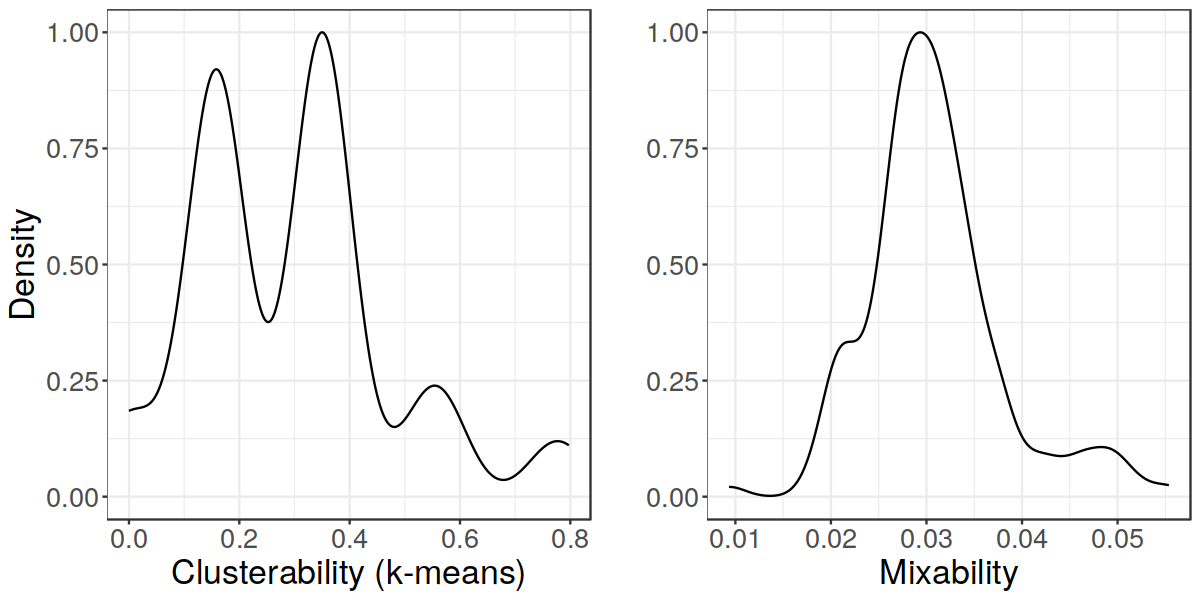

In [6]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-ggplot(res.df, aes(x=gold_clusterability.kmeans))+ 
   geom_density(aes(y = ..scaled..)) + theme_bw() + ylab('Density') + xlab('Clusterability (k-means)') + 
theme(text=element_text(size=20))
g1B<-ggplot(res.df, aes(x=gold_clusterability.louvain))+ 
   geom_density(aes(y = ..scaled..)) + theme_bw() + ylab('Density') + xlab('Clusterability (Louvain)') + 
theme(text=element_text(size=20))
g1C<-ggplot(res.df, aes(x=gold_mixability))+ 
   geom_density(aes(y = ..scaled..)) + theme_bw() + ylab('') + xlab('Mixability') + 
theme(text=element_text(size=20))

g1B<-ggarrange(g1A, g1C, ncol = 2, nrow = 1)

fn<-'gold_standard_batch_severity_dist'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g1B, 
                                             height = h_, width = w_)}

g1B

The kmeans clusterability does havfe a wide-range, so this may not be a great metric to proceed with. However, Louvain is constantly 0 and Mixability is limited to very low values. 

#### Question 2: Do the batch severity metrics increase when increasing the Splatter parameters that introduce batch severity (sanity check)

In [7]:
count.types<-c('gold', 'log', 'scanorama', 'scvi')
batch.severity.metrics<-c('clusterability.kmeans', 'clusterability.louvain', 'mixability')

mod.res <- data.frame(matrix(ncol = 6, nrow = 0))
colnames(mod.res)<-c('coefficient', 'Estimate','Pr(>|t|)','BH.FDR','count.type','batch.severity.metric')

for (count.type in count.types){
    for (batch.severity.metric in batch.severity.metrics){
        metric<-paste0(count.type, '_', batch.severity.metric)
        metric.formula<-as.formula(paste0(metric, ' ~ n.batches + batch.scale + batch.location'))
        mod<-glm(metric.formula, data = res.df)
        mod.res_<-as.data.frame(coef(summary(mod))[, c('Estimate', 'Pr(>|t|)')])
        mod.res_[['BH.FDR']]<-unname(unlist(p.adjust(mod.res_[, 2], method = "BH")))

        mod.res_[['count.type']]<-count.type
        mod.res_[['batch.severity.metric']]<-batch.severity.metric
        
        mod.res_ <- mod.res_ %>% tibble::rownames_to_column("coefficient")
        mod.res_[mod.res_$coefficient == ('(Intercept)'), 'coefficient']<-'Intercept'
        
        mod.res<-rbind(mod.res, mod.res_)
    }
}

# mapping for visualization
coefficient_map<-c('Intercept', 'No. Batches', 'Batch Scale', 'Batch Location')
names(coefficient_map)<-c('Intercept', 'n.batches', 'batch.scale', 'batch.location')
mod.res[['coefficient']]<-factor(unlist(unname(coefficient_map[mod.res$coefficient])), 
                                 levels = unlist(unname(coefficient_map)))

batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('clusterability.kmeans', 'clusterability.louvain', 'mixability')
mod.res[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[mod.res$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

count.type.map<-c('Gold-Standard', 'Log-normalized', 'Scanorama', 'scVI')
names(count.type.map)<-c('gold', 'log', 'scanorama', 'scvi')
mod.res[['count.type']]<-factor(unlist(unname(count.type.map[mod.res$count.type])), 
                                 levels = unlist(unname(count.type.map)))

sig.thresh<-0.1
mod.res[['Significant']]<-'no'
# include NA since these are not changing
mod.res[(!is.na(mod.res$BH.FDR)) & (mod.res$BH.FDR <= sig.thresh), 'Significant']<-'yes'
mod.res[['Significant']]<-factor(mod.res$Significant, levels = c('yes', 'no'))

Note, the gold-standard and scanorama counts matrices do not have significance values for Louvain clusterability because the batch-severity metric never changes from zero:

In [8]:
mod.res[is.na(mod.res$BH.FDR), ]

unique(res.df$gold_clusterability.louvain)
unique(res.df$scanorama_clusterability.louvain)

,coefficient,Estimate,Pr(>|t|),BH.FDR,count.type,batch.severity.metric,Significant
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
5,Intercept,0,NaN,NaN,Gold-Standard,Clusterability (Louvain),no
6,No. Batches,0,NaN,NaN,Gold-Standard,Clusterability (Louvain),no
7,Batch Scale,0,NaN,NaN,Gold-Standard,Clusterability (Louvain),no
8,Batch Location,0,NaN,NaN,Gold-Standard,Clusterability (Louvain),no
29,Intercept,0,NaN,NaN,Scanorama,Clusterability (Louvain),no
30,No. Batches,0,NaN,NaN,Scanorama,Clusterability (Louvain),no
31,Batch Scale,0,NaN,NaN,Scanorama,Clusterability (Louvain),no
32,Batch Location,0,NaN,NaN,Scanorama,Clusterability (Louvain),no


[1] 0

[1] 0

Let's see how the parameters affect each severity metric for each counts matrix using an additive GLM (each Splat parameter is a ind. variable, the batch severity is the dependent varible):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


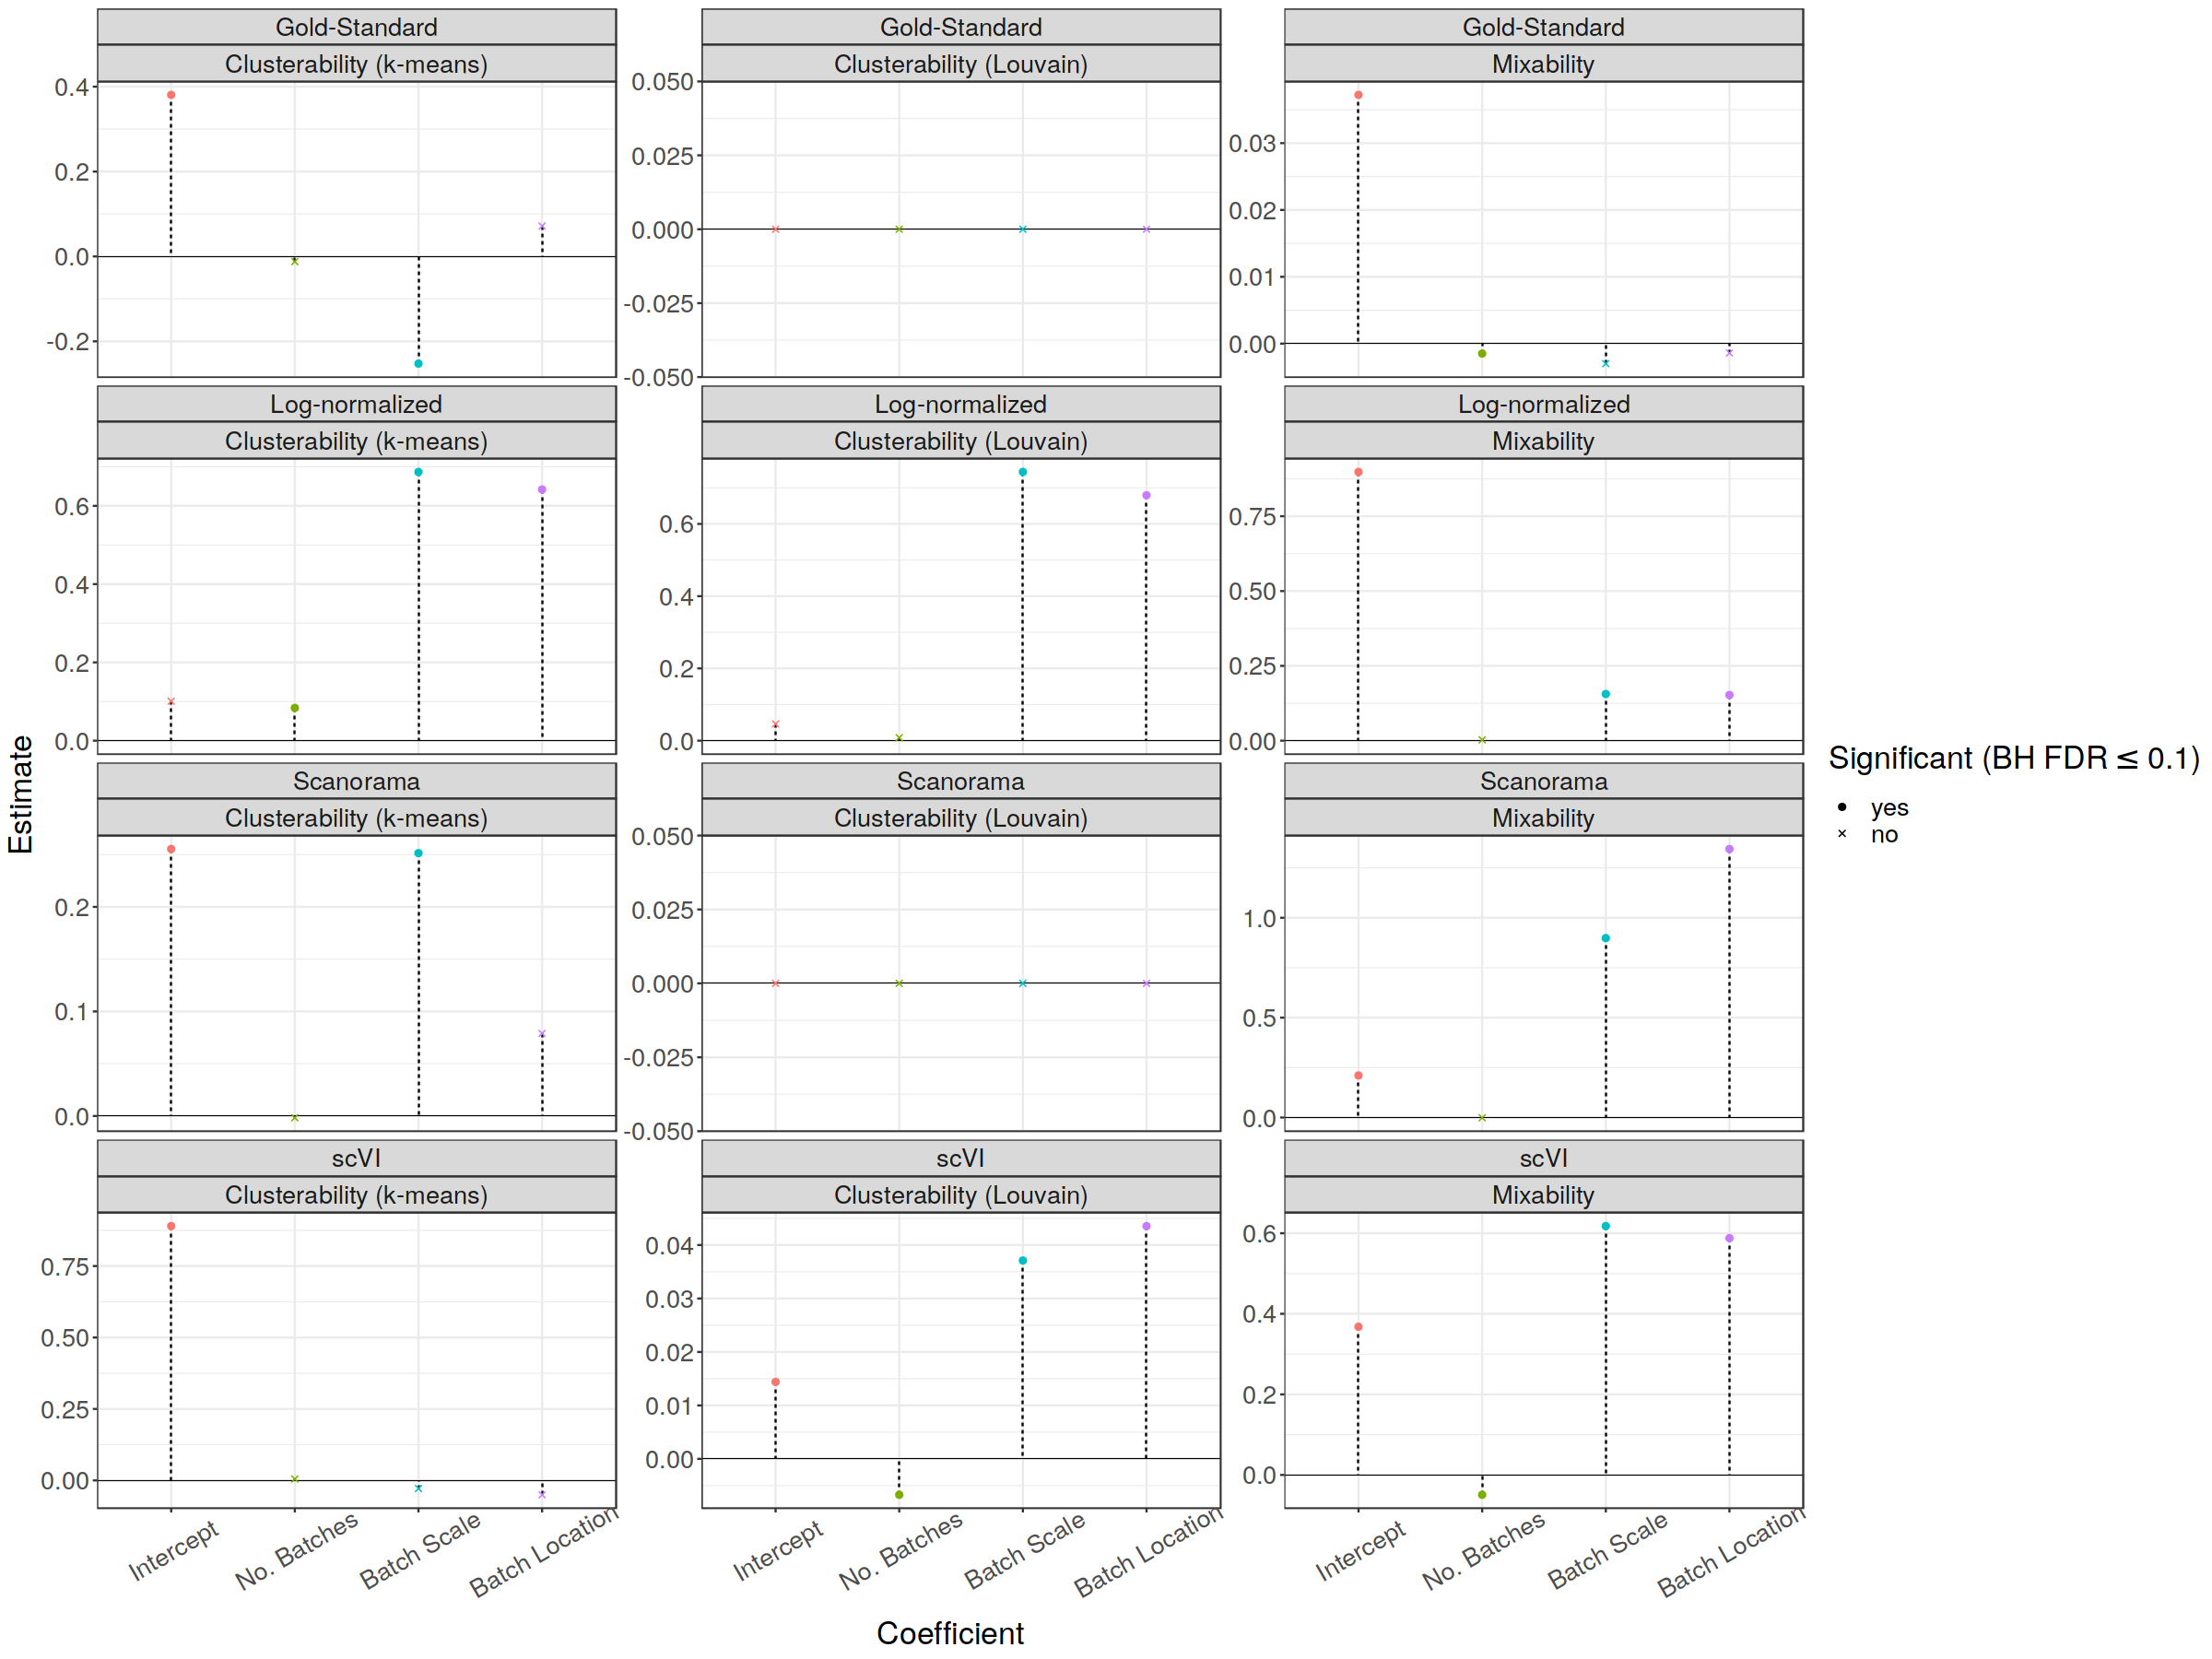

In [9]:
h_ = 15
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2<-ggplot(data = mod.res, aes(x = coefficient, y = Estimate, color = coefficient)) +
geom_hline(yintercept = 0, size = 0.25)+
geom_segment(aes(x=coefficient, xend=coefficient, y=Estimate, yend=0), 
        size=0.5, data=mod.res, color = 'black', linetype="dashed") +
geom_point(aes(shape = Significant)) + scale_shape_manual(name = expression('Significant (BH FDR' <= '0.1)'), 
                                                          values=c(19,4), drop = F) + 
theme_bw() + theme(axis.text.x = element_text(angle = 30, vjust = 0.7, hjust=0.5), 
                  text=element_text(size=20)) +
facet_wrap(count.type ~ batch.severity.metric, scales = "free_y", ncol = 3) + guides(color = F) + 
xlab('Coefficient')

fn<-'splatter_param_glms'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g2, 
                                             height = h_, width = w_)}

g2

Our expectation is that the gold-standard (no bach-effects) as well as batch corrected counts should have low batch severity that is unaffected by the Splatter parameters. In contrast, the log-normalized counts matrix batch severity should increase with the Splatter parameters. 

For the gold-standard (no batch-effects), we expect that batch severity should not change with Splatter parameters:
- kmeans: high batch severity at Splatter parameters being 0 (intercept), indicating kmeans may not be a great metric and we may want to exclude it (agrees with above). However, the Splatter parameters n.batches and batch.location do not effect the severity, and batch.scale slightly decreases with increasing Splatter parameter, indicating this is pretty random. Can maybe used, just with a higher baseline severity. 
- Louvain: unchanging across Splatter parameters as expected
- mixability: accounting for effect sizes, essentially unchanging across everity. 

Log-counts: batch-severity seems to increase with Splatter parameters (batch.scale and batch.location), as expected. 

For scanorama:
- kmeans clusterability: while batch severity increases with batch.scale, the effects are smaller than the log-counts (and batch.location significance is lost), indicating the batch correction is working
- louvain clusterability: no batch effects after batch correction as expected
- mixability: severity increases rapidly with batch.scale and batch.location, however it starts off at a lower value (intercept) than the log-counts. We may want to exclude this in downstream analyses

For scvi:
- kmeans: similar to gold-standard kmeans; high overall severity, but does not change with the splatter parameters
- louvain: similar to gold-standard mixability -- while we have significance, effect sizes are very small, so this is essentially behaving as expected
- mixability: similar to scanorama mixability

Overall, things are behaving close to what is expected, but not perfectly. Going forward, we may consider excluding the gold-standard and scvi kmeans as well as the batch-corrected mixability. For these ones that we are hesitant about, let's look in more detail at them visually:

In [10]:
viz.df<-res.df
viz.df[['n.batches']]<-factor(viz.df$n.batches, levels = sort(unique(viz.df$n.batches)))
viz.df[['batch.scale']]<-factor(viz.df$batch.scale, levels = sort(unique(viz.df$batch.scale)))
viz.df[['batch.location']]<-factor(viz.df$batch.location, levels = sort(unique(viz.df$batch.scale)))

In [11]:
batch.severity.metric<-'clusterability.kmeans'
viz.df_<-viz.df[c('n.batches', 'batch.scale', 'batch.location', paste(count.types, batch.severity.metric, sep = '_'))]
viz.df_<-reshape2::melt(viz.df_, id.vars = c('n.batches', 'batch.scale', 'batch.location'), 
                        value.name = 'batch.severity')
viz.df_<-viz.df_ %>% tidyr::separate(variable, c("count.type", "batch.severity.metric"), "_")
viz.df_<-reshape2::melt(viz.df_, id.vars = c('count.type', 'batch.severity.metric', 'batch.severity'), 
                        value.name = 'sp.value', varnames = c('Splatter.param'))
names(viz.df_)[names(viz.df_) == 'variable'] = 'Splatter.param'


# mapping for visualization
coefficient_map<-c('No. Batches', 'Batch Scale', 'Batch Location')
names(coefficient_map)<-c('n.batches', 'batch.scale', 'batch.location')
viz.df_[['Splatter.param']]<-factor(unlist(unname(coefficient_map[viz.df_$Splatter.param])), 
                                 levels = unlist(unname(coefficient_map)))

batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('clusterability.kmeans', 'clusterability.louvain', 'mixability')
viz.df_[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df_$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

count.type.map<-c('Gold-Standard', 'Log-normalized', 'Scanorama', 'scVI')
names(count.type.map)<-c('gold', 'log', 'scanorama', 'scvi')
viz.df_[['count.type']]<-factor(unlist(unname(count.type.map[viz.df_$count.type])), 
                                 levels = unlist(unname(count.type.map)))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


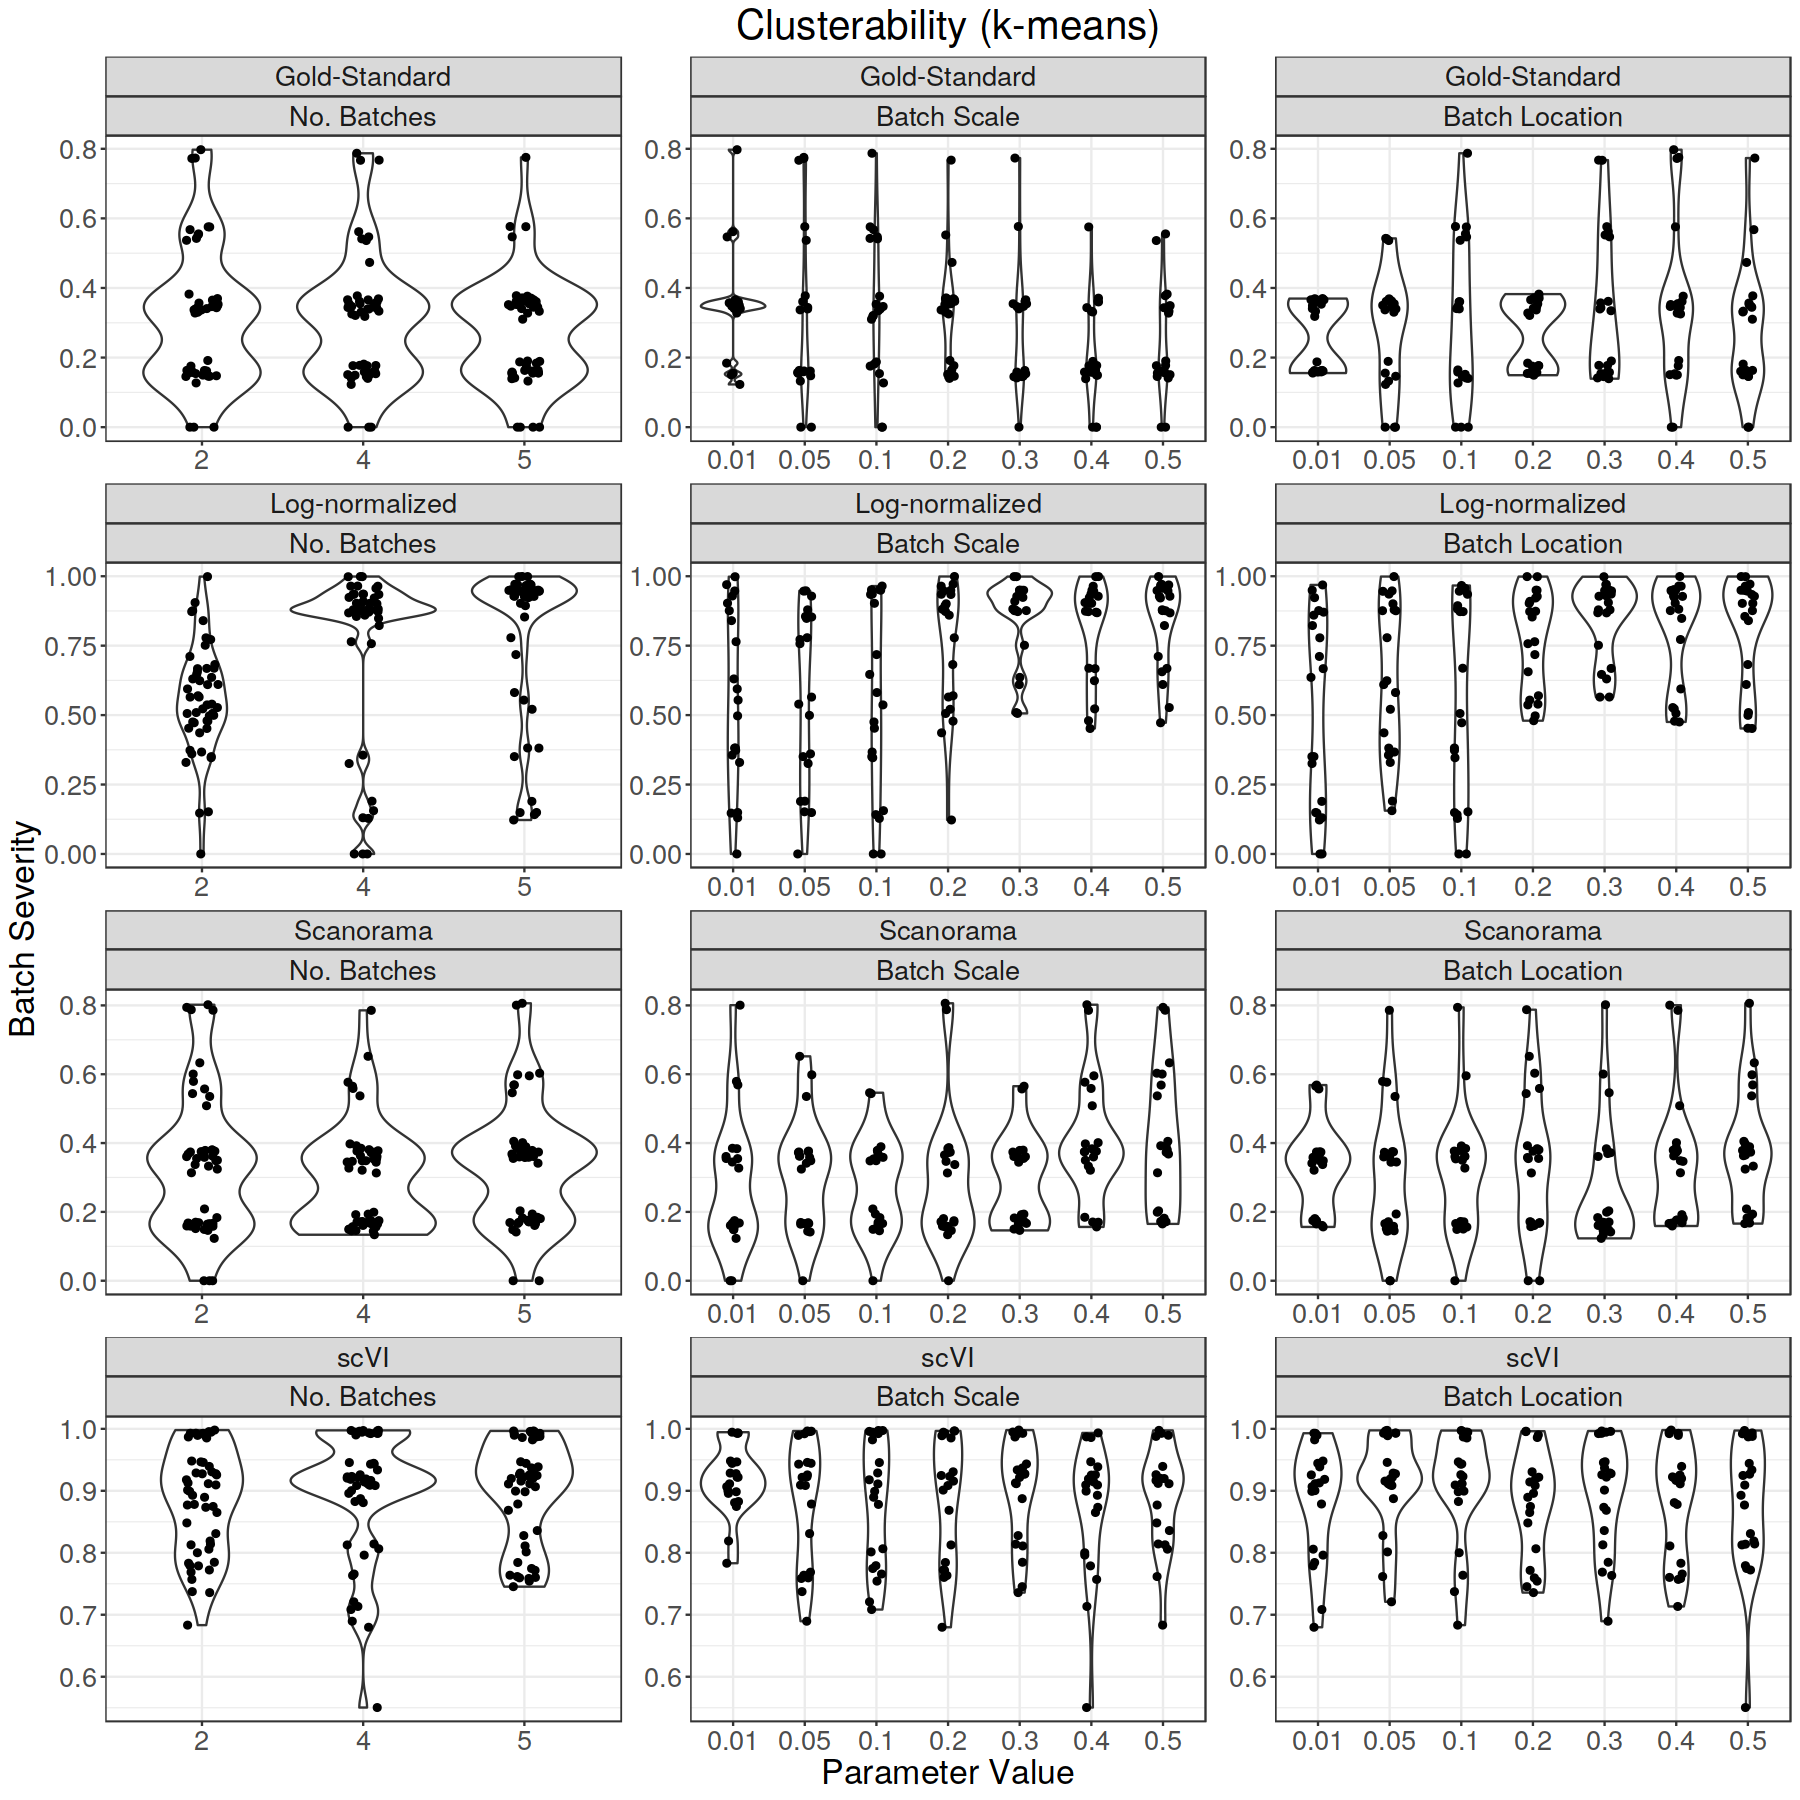

In [12]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g3<-ggplot(data = viz.df_, aes(x = sp.value, y = batch.severity)) + 
geom_violin() + geom_jitter(height = 0, width = 0.1) + 
ggtitle(unique(viz.df_$batch.severity.metric)) + 
facet_wrap(count.type ~ Splatter.param, scales = "free", ncol = length(unique(viz.df_$Splatter.param))) + 
theme_bw() + theme(plot.title = element_text(hjust = 0.5), text=element_text(size=20)) + 
xlab('Parameter Value') + ylab('Batch Severity')

fn<-'clusterability_kmeans_splatter_param_violin'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g3, 
                                             height = h_, width = w_)}

g3

Visually, we can see that the log-normalized kmeans clusterability seems to increase with the Splatter params more drastically than the gold-standard or batch-corrected counts. So, for now, let's retain the kmeans metric. To further confirm this, let's run a Mann-Whitney U test to test whether the k-means clusterability of the gold-standard matrix is lower than that of the log-normalized matrix across all iterations:

In [13]:
gs_bs<-viz.df_[viz.df_$count.type == 'Gold-Standard', 'batch.severity']
ln_bs<-viz.df_[viz.df_$count.type == 'Log-normalized', 'batch.severity']
p.val<-wilcox.test(x = gs_bs, y = ln_bs, alternative = 'less')$p.value
paste0('The gold-standard batch severity as measured by k-means is statistically significantly lower than that of ', 
      'the log-normalized batch severity (p = ', 
      formatC(p.val, format = "e", digits = 3), ')')

[1] "The gold-standard batch severity as measured by k-means is statistically significantly lower than that of the log-normalized batch severity (p = 7.138e-79)"

Finally, although our GLMs indicated that Louvain is working as expected, let's also visualize it:

In [14]:
batch.severity.metric<-'clusterability.louvain'
viz.df_<-viz.df[c('n.batches', 'batch.scale', 'batch.location', paste(count.types, batch.severity.metric, sep = '_'))]
viz.df_<-reshape2::melt(viz.df_, id.vars = c('n.batches', 'batch.scale', 'batch.location'), 
                        value.name = 'batch.severity')
viz.df_<-viz.df_ %>% tidyr::separate(variable, c("count.type", "batch.severity.metric"), "_")
viz.df_<-reshape2::melt(viz.df_, id.vars = c('count.type', 'batch.severity.metric', 'batch.severity'), 
                        value.name = 'sp.value', varnames = c('Splatter.param'))
names(viz.df_)[names(viz.df_) == 'variable'] = 'Splatter.param'

# mapping for visualization
coefficient_map<-c('No. Batches', 'Batch Scale', 'Batch Location')
names(coefficient_map)<-c('n.batches', 'batch.scale', 'batch.location')
viz.df_[['Splatter.param']]<-factor(unlist(unname(coefficient_map[viz.df_$Splatter.param])), 
                                 levels = unlist(unname(coefficient_map)))

batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('clusterability.kmeans', 'clusterability.louvain', 'mixability')
viz.df_[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df_$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

count.type.map<-c('Gold-Standard', 'Log-normalized', 'Scanorama', 'scVI')
names(count.type.map)<-c('gold', 'log', 'scanorama', 'scvi')
viz.df_[['count.type']]<-factor(unlist(unname(count.type.map[viz.df_$count.type])), 
                                 levels = unlist(unname(count.type.map)))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


Warning message:
“Removed 231 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 231 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 231 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 231 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”


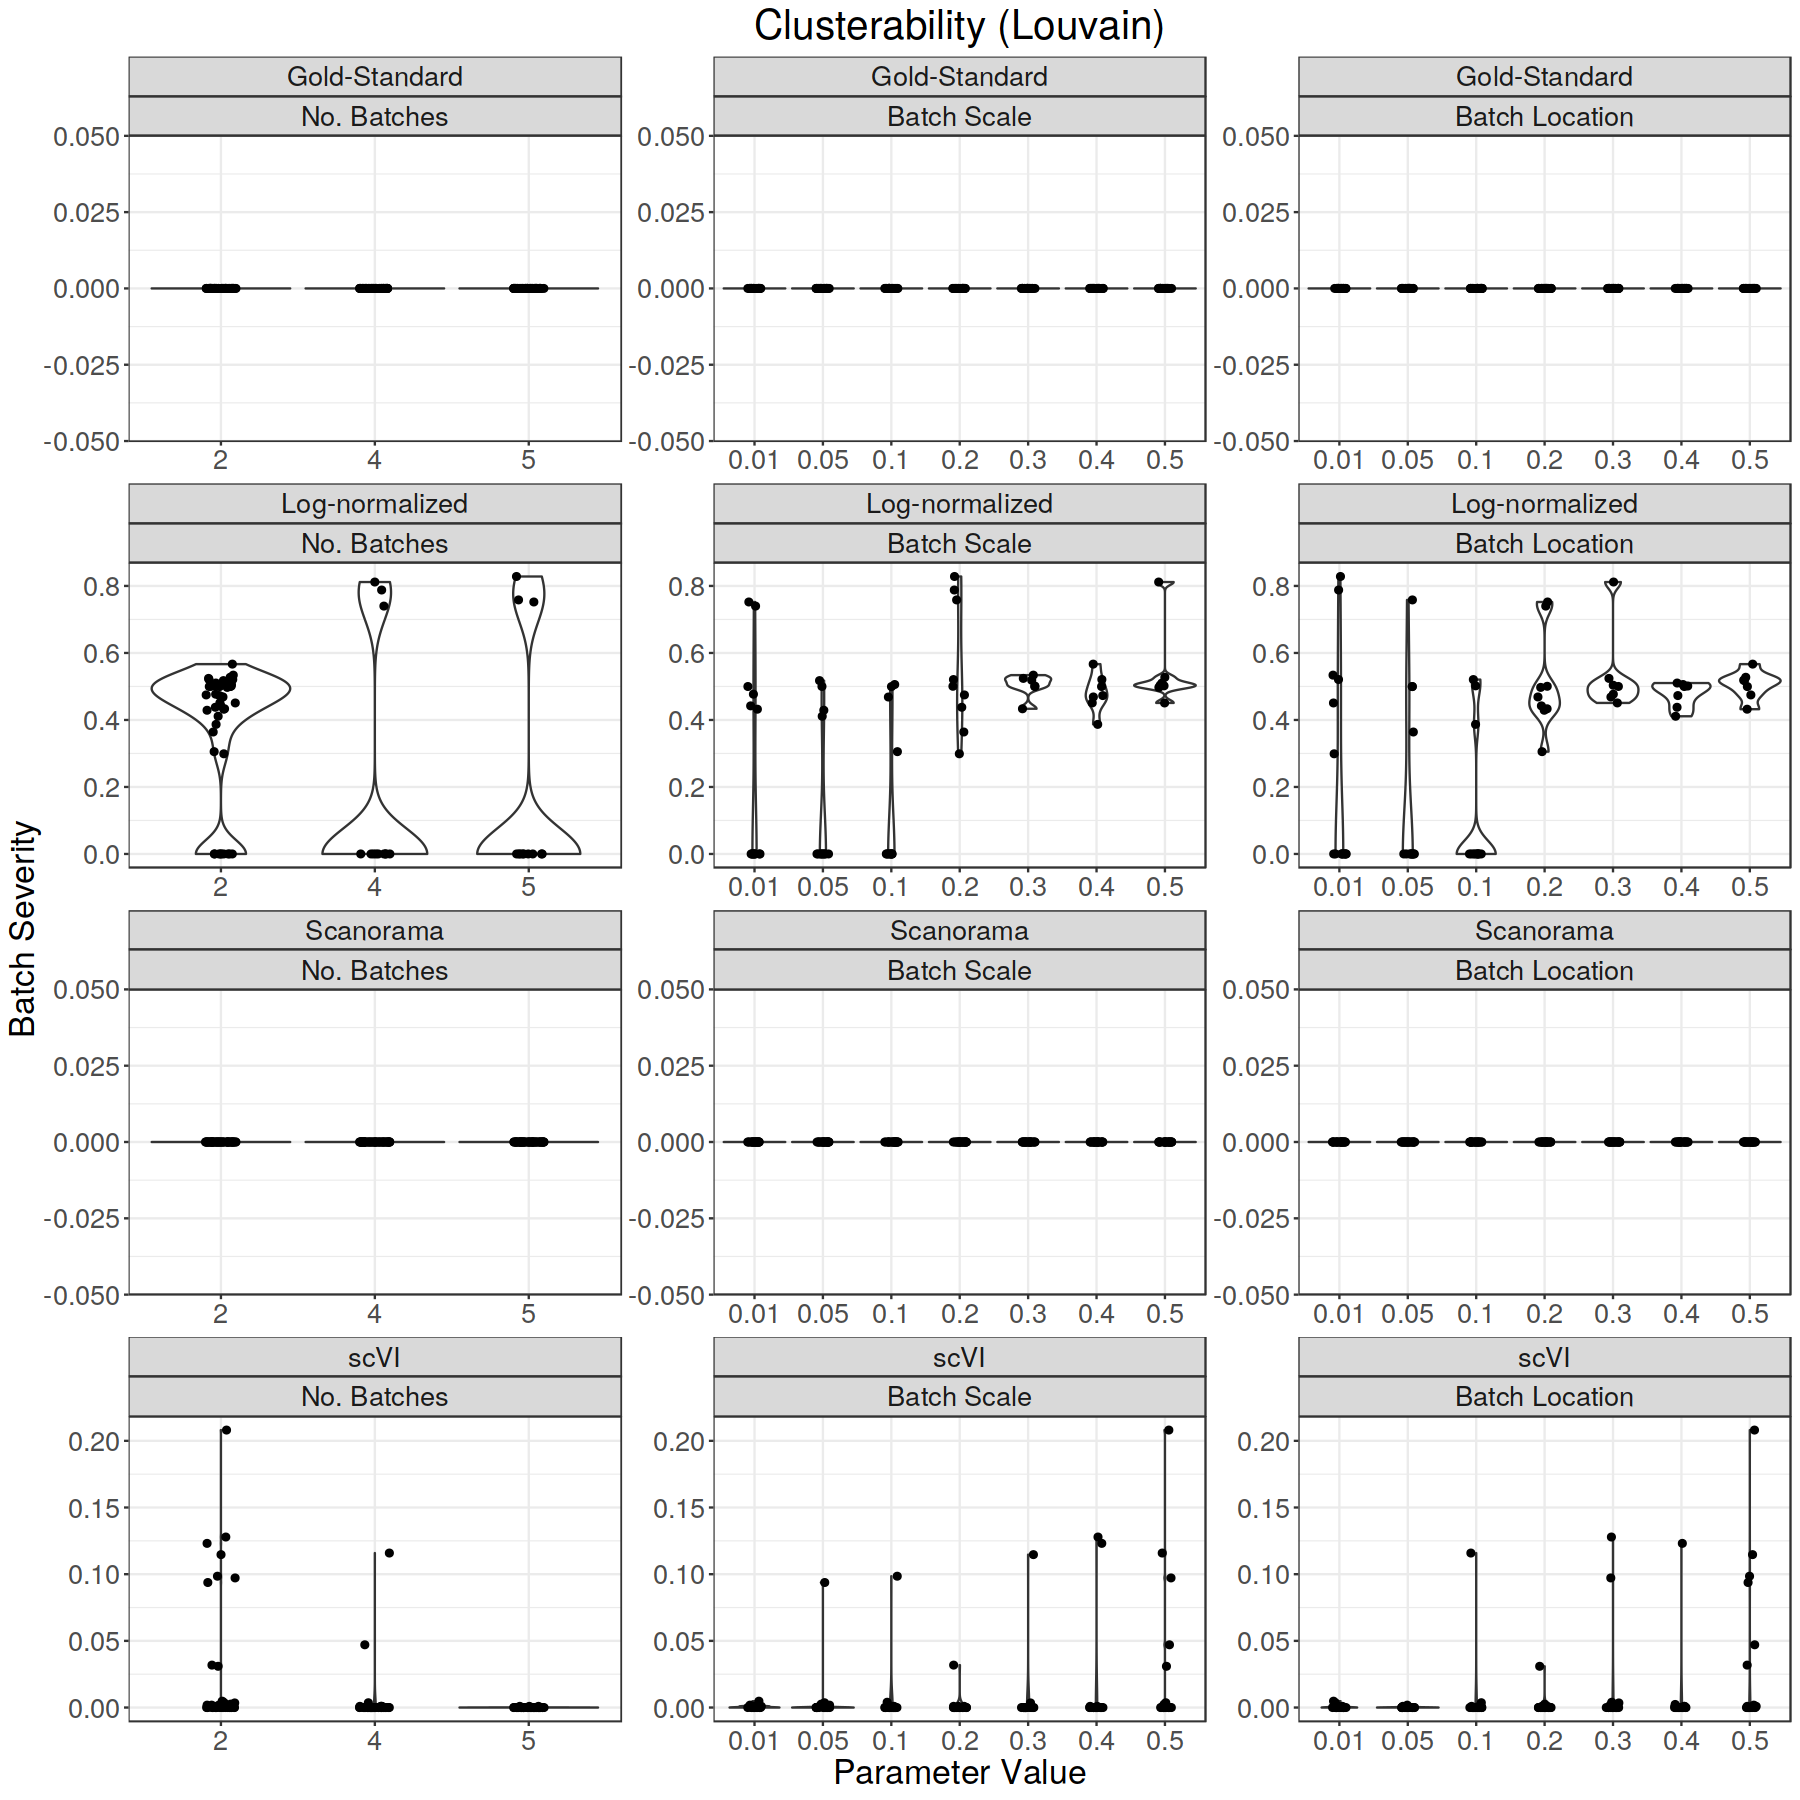

In [15]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g3<-ggplot(data = viz.df_, aes(x = sp.value, y = batch.severity)) + 
geom_violin() + geom_jitter(height = 0, width = 0.1) + 
ggtitle(unique(viz.df_$batch.severity.metric)) + 
facet_wrap(count.type ~ Splatter.param, scales = "free", ncol = length(unique(viz.df_$Splatter.param))) + 
theme_bw() + theme(plot.title = element_text(hjust = 0.5), text=element_text(size=20)) + 
xlab('Parameter Value') + ylab('Batch Severity')

fn<-'clusterability_louvain_splatter_param_violin'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g3, 
                                             height = h_, width = w_)}

g3

For now, based on the GLM and violin plots, we can conclude that batch severity is changing with the Splatter parameters as expected in each counts matrix for each severity metric, so we proceed with the dataset intact. 

In [16]:
batch.severity.metric<-'mixability'
viz.df_<-viz.df[c('n.batches', 'batch.scale', 'batch.location', paste(count.types, batch.severity.metric, sep = '_'))]
viz.df_<-reshape2::melt(viz.df_, id.vars = c('n.batches', 'batch.scale', 'batch.location'), 
                        value.name = 'batch.severity')
viz.df_<-viz.df_ %>% tidyr::separate(variable, c("count.type", "batch.severity.metric"), "_")
viz.df_<-reshape2::melt(viz.df_, id.vars = c('count.type', 'batch.severity.metric', 'batch.severity'), 
                        value.name = 'sp.value', varnames = c('Splatter.param'))
names(viz.df_)[names(viz.df_) == 'variable'] = 'Splatter.param'

# mapping for visualization
coefficient_map<-c('No. Batches', 'Batch Scale', 'Batch Location')
names(coefficient_map)<-c('n.batches', 'batch.scale', 'batch.location')
viz.df_[['Splatter.param']]<-factor(unlist(unname(coefficient_map[viz.df_$Splatter.param])), 
                                 levels = unlist(unname(coefficient_map)))

batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('clusterability.kmeans', 'clusterability.louvain', 'mixability')
viz.df_[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df_$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

count.type.map<-c('Gold-Standard', 'Log-normalized', 'Scanorama', 'scVI')
names(count.type.map)<-c('gold', 'log', 'scanorama', 'scvi')
viz.df_[['count.type']]<-factor(unlist(unname(count.type.map[viz.df_$count.type])), 
                                 levels = unlist(unname(count.type.map)))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


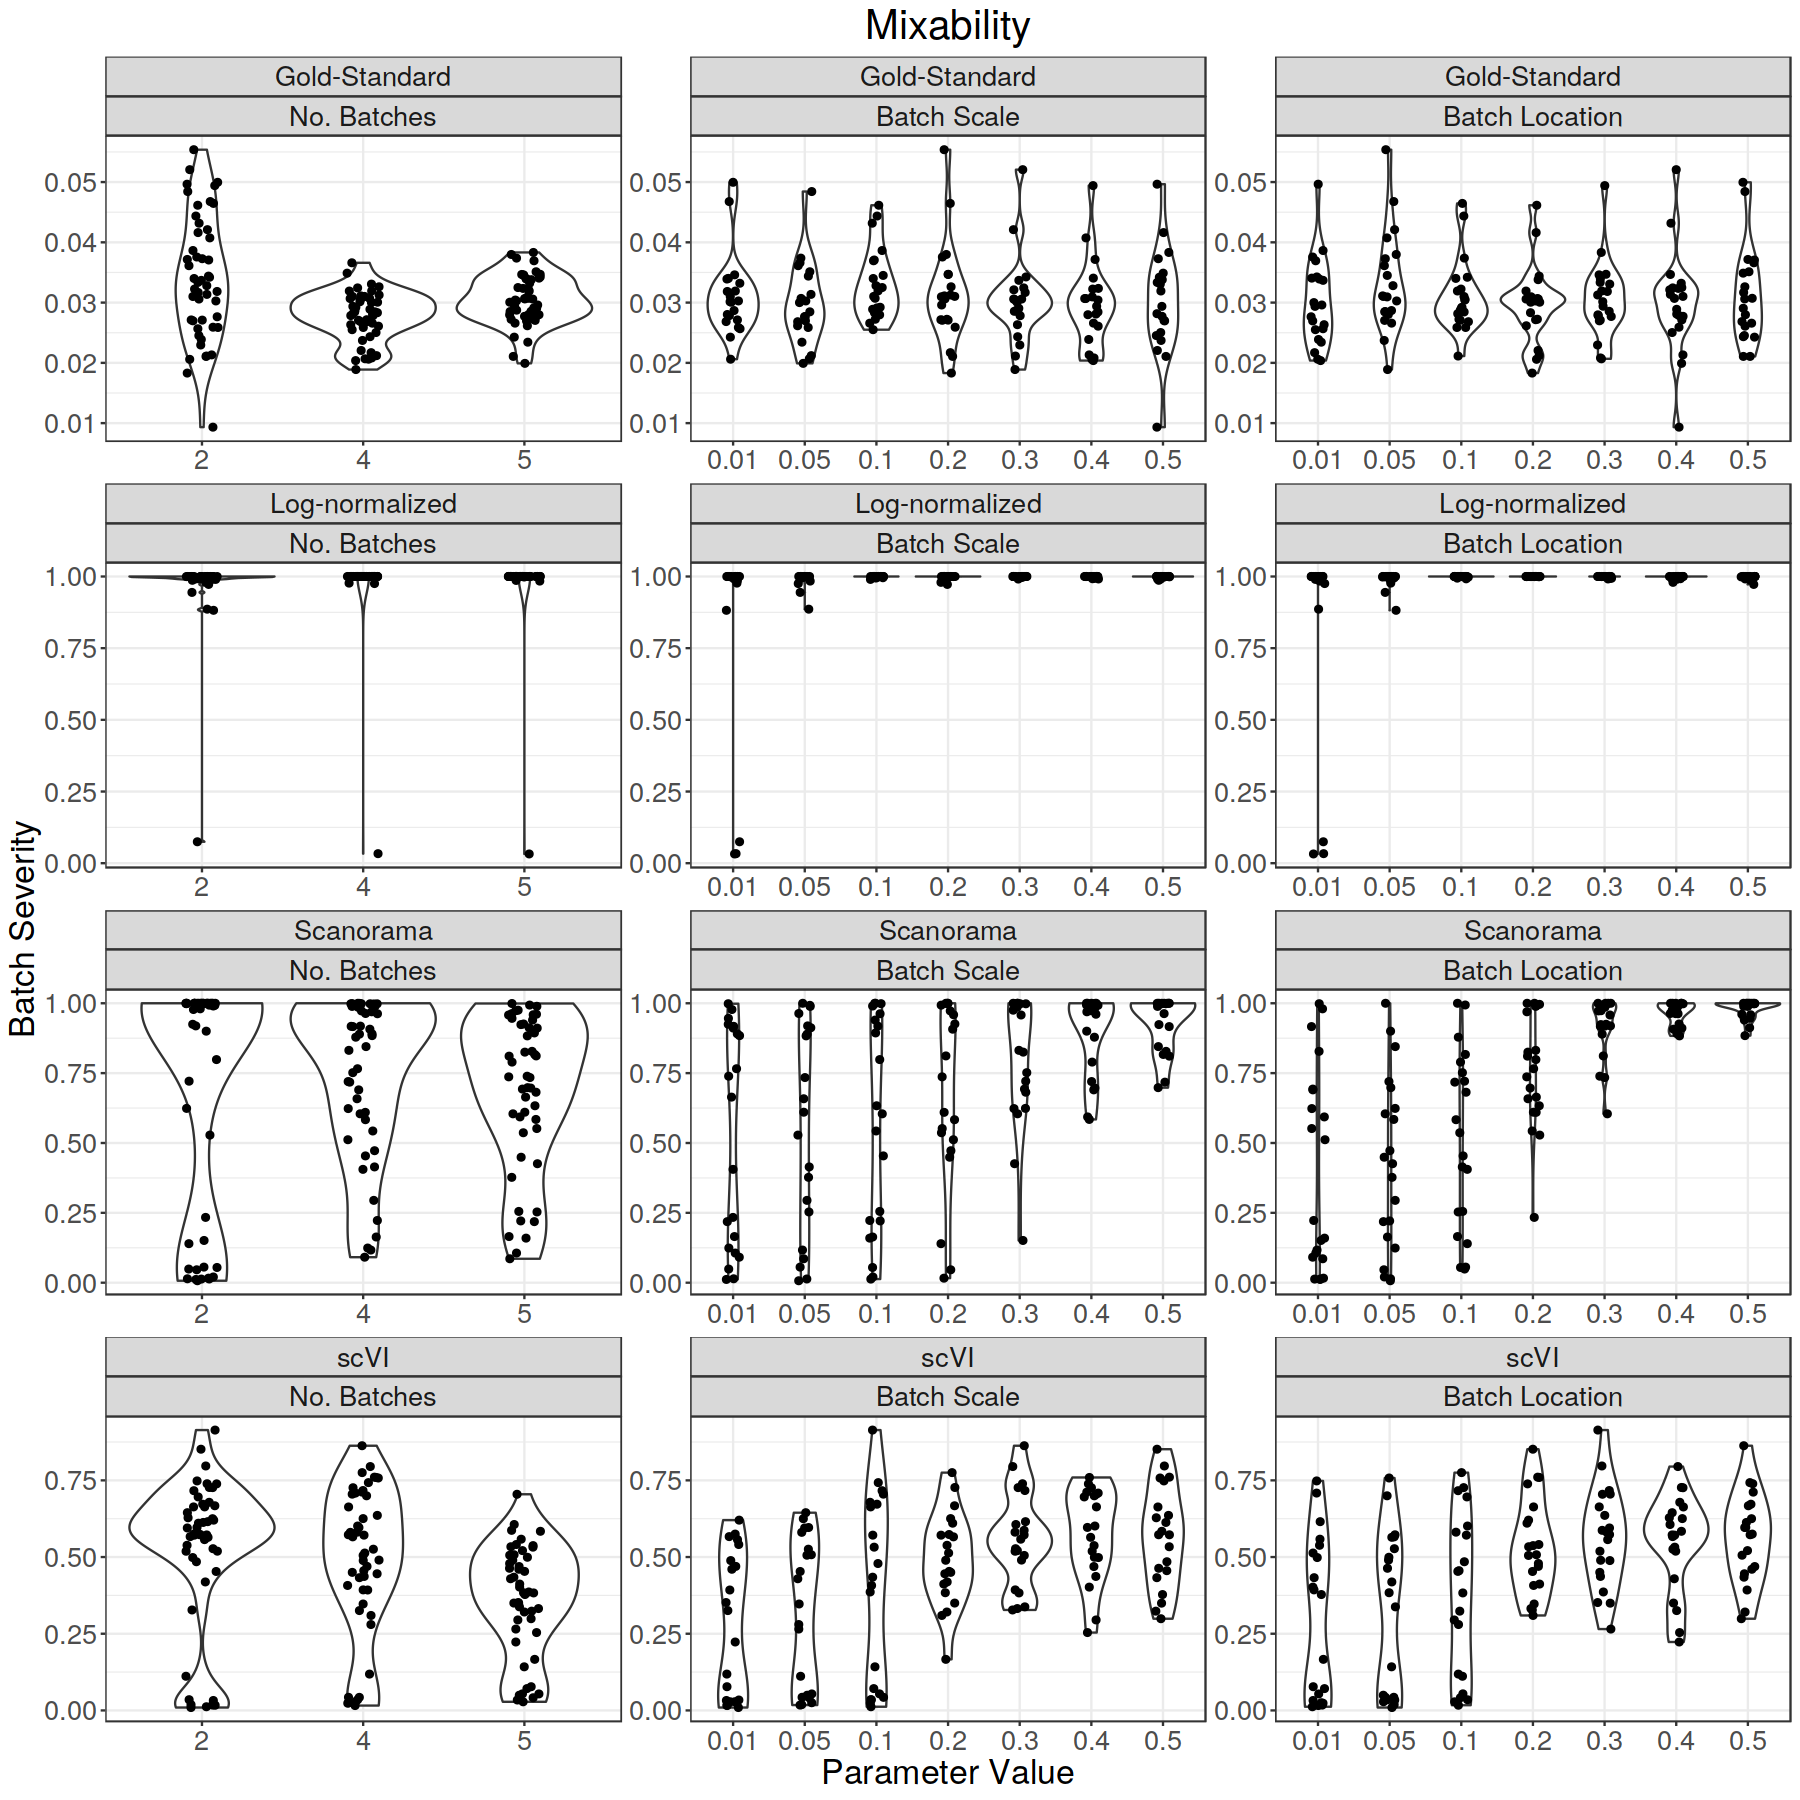

In [17]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g3<-ggplot(data = viz.df_, aes(x = sp.value, y = batch.severity)) + 
geom_violin() + geom_jitter(height = 0, width = 0.1) + 
ggtitle(unique(viz.df_$batch.severity.metric)) + 
facet_wrap(count.type ~ Splatter.param, scales = "free", ncol = length(unique(viz.df_$Splatter.param))) + 
theme_bw() + theme(plot.title = element_text(hjust = 0.5), text=element_text(size=20)) + 
xlab('Parameter Value') + ylab('Batch Severity')

fn<-'mixability_splatter_param_violin'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g3, 
                                             height = h_, width = w_)}

g3

Again, we can see visually, the mixability batch severity in the log-counts is increasing more drastically than the batch-corrected data (despite the gold-standard being lower severity and not increasing at all). This indicates that the batch correction is improving batch effects, but not returning it back to the gold-standard. So, we can retain these metrics for now too.

#### Question 3: At what level of batch severity can the tensor decomposition no long recover the signal?

For this question, we want to use the CorrIndex comparing the decomposition output of the log-normalized counts matrix (since it does not have a batch correction), to the gold-standard decomposition output.

In [18]:
get_severity_reg<-function(df){#, Similarity, batch.severity){
    mod = glm(data = df, formula = Similarity ~ batch.severity)
    mod.res<-as.data.frame(coef(summary(mod))[, c('Estimate', 'Pr(>|t|)')])
    mod.res[['BH.FDR']]<-unname(unlist(p.adjust(mod.res[, 2], method = "BH")))
    mod.res<-as.list(mod.res['batch.severity', c('Estimate', 'BH.FDR')])
    
    return(mod.res)
}

In [19]:
get.severity.reg<-function(data){
    mod = glm(data = data, formula = Similarity ~ batch.severity)
    mod.res<-as.data.frame(coef(summary(mod)))[, c('Estimate', 'Pr(>|t|)')]
    mod.res[['BH.FDR']]<-unname(unlist(p.adjust(mod.res[, 2], method = "BH")))
    mod.res<-as.list(mod.res['batch.severity', c('Estimate', 'BH.FDR')])
    
    return(mod.res)
}

In [20]:
viz.df<-res.df[c('corr.index.log', paste('log', batch.severity.metrics, sep = '_'))]
viz.df<-reshape2::melt(viz.df, id.vars = c('corr.index.log'), value.name = 'batch.severity')%>% 
    dplyr::rename(batch.severity.metric = names(.)[2], 
                 Similarity = names(.)[1])

spearman.corrs<-viz.df %>% 
    group_by(batch.severity.metric) %>%
    summarize(correlation = cor(Similarity, batch.severity, method = "sp", use = 'pairwise.complete.obs'))

reg.coefs<-viz.df %>% 
    group_by(batch.severity.metric) %>%
    do(Estimate = get.severity.reg(data = .)) %>%
    tidyr::unnest_wider(Estimate)

viz.df.stats<-dplyr::left_join(spearman.corrs,reg.coefs)


# mapping for visualization
batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('log_clusterability.kmeans', 'log_clusterability.louvain', 'log_mixability')
viz.df[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('log_clusterability.kmeans', 'log_clusterability.louvain', 'log_mixability')
viz.df.stats[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df.stats$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

Joining with `by = join_by(batch.severity.metric)`


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 77 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 77 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 77 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 77 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 77 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 77 rows containing missing values (`geom_point()`).”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -2.59e-03 (FDR: 2.83e-01)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -2.59e-03 (FDR: 2.83e-01)' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call.g

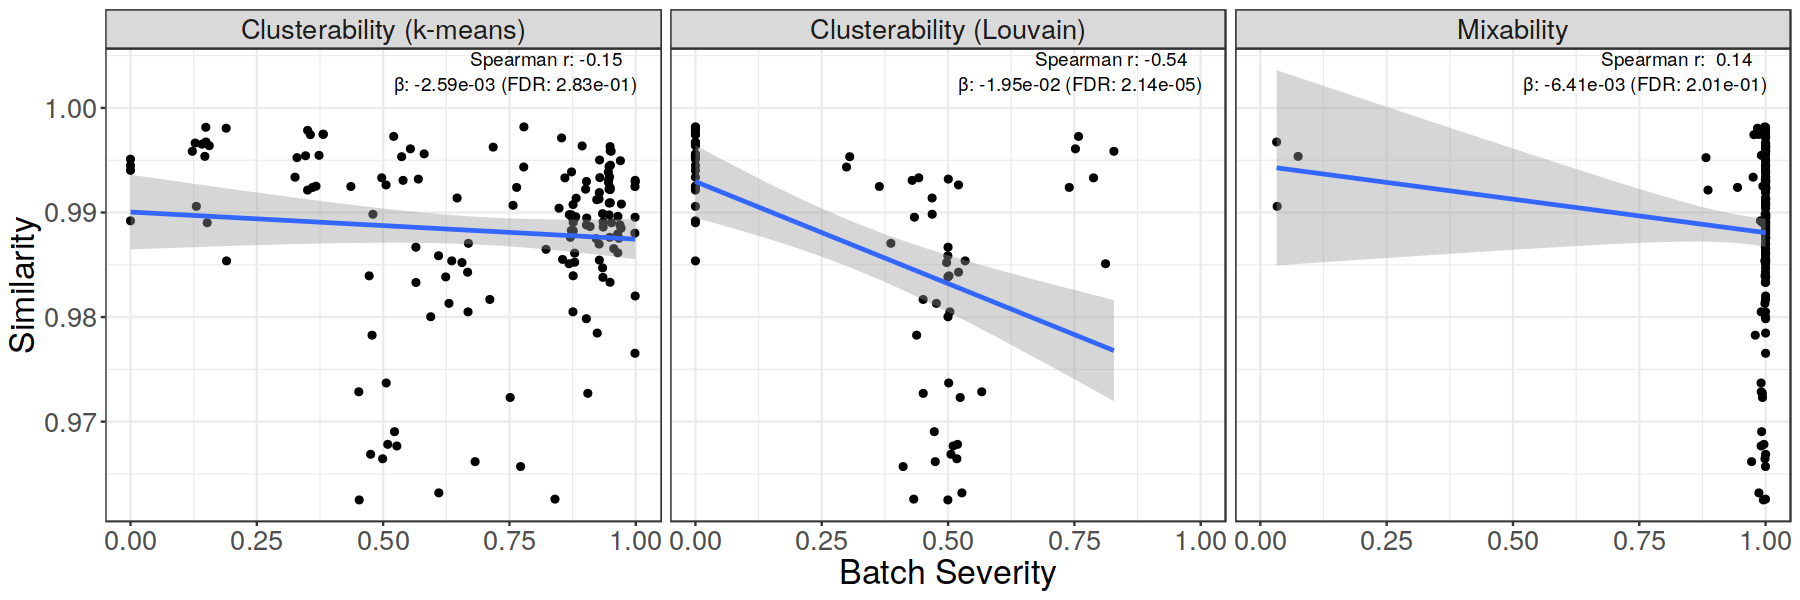

In [21]:
h_ = 5
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g<-ggplot(data = viz.df, aes(x = batch.severity, y = Similarity)) + 
geom_point() + geom_smooth(method = glm) +
facet_wrap(~batch.severity.metric, ncol = 3) + 
geom_text(data = data.frame(viz.df.stats),
          mapping = aes(x = Inf, y = Inf, label = paste0('Spearman r: ', format(round(correlation, 2), nsmall = 2))), 
         hjust = 1.25, vjust = 1.25) +
geom_text(data = data.frame(viz.df.stats),
          mapping = aes(x = Inf, y = Inf, label = paste0("\U03B2", ': ', 
                                                           formatC(Estimate, format = "e", digits = 2),
                                                           ' (FDR: ', 
                                                          formatC(BH.FDR, format = "e", digits = 2), 
                                                          ')')), 
         hjust = 1.1,vjust   = 3) +
xlab('Batch Severity') +
theme_bw() + theme(text=element_text(size=20))

fn<-'log_similarity_effect'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g, 
                                             height = h_, width = w_)}

g

In [22]:
paste0('Across all severity metrics, batch severity does not decrease beyond ', 
      format(round(min(viz.df$Similarity), 3), nsmall = 3))

[1] "Across all severity metrics, batch severity does not decrease beyond 0.963"

The Similarity (y-axis) is that between the decompositions run on the log-counts and gold-standard (no batch effects) counts at varying levels of batch severity (x-axis)

While Similarity does decrease with batch severity for two of the three metrics (miaxability excluded), the effect sizes are quite small. So, even at high levels of batch severity, the CorrIndex is still high, indicating that decomposition is robust to batch effects and batch correction may not be necessary. 

#### Question 4: How does batch correction affect the decomposition?

In instances where the user still wants/needs to run a batch correction, let's see how the decomposition performs. 

#### 4A: Does the fraction of negative counts introduced by batch correction affect the decomposition?

One of the two batch correction methods we used, Scanorama, introduces negative values to the corrected counts matrix. This is what most batch correction methods that are capable of returning corrected counts do. In our pipeline (see [notebook 01](./01_benchmark_iteration.ipynb)), we replace these with 0 and in our [README](./README.md) include a discussion on why this may or may not affect results.  

First, let's see if the fraction of negative counts introduced changes with batch severity, because if this is the case, it may be a confounder in assessing whether this has an affect on similarity:

In [23]:
viz.df<-res.df[c('scanorama_frac.negative', 'scanorama_clusterability.kmeans', 
                'scanorama_clusterability.louvain', 'scanorama_mixability')]
viz.df<-reshape2::melt(viz.df, id.vars = 'scanorama_frac.negative', variable.name = 'batch.severity.metric', 
              value.name = 'batch.severity')

# mapping for visualization
batch.metric.map<-c('Clusterability (Louvain)', 'Clusterability (k-means)', 'Mixability')
names(batch.metric.map)<-c('scanorama_clusterability.louvain', 'scanorama_clusterability.kmeans', 'scanorama_mixability')
viz.df[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[as.character(viz.df$batch.severity.metric)])), 
                                 levels = unlist(unname(batch.metric.map)))

# Louvain is all 0s
viz.df_ = viz.df[viz.df$batch.severity.metric != 'Clusterability (Louvain)',]

spearman.corrs<-viz.df_ %>% 
    group_by(batch.severity.metric) %>%
    summarize(correlation = cor(scanorama_frac.negative, batch.severity, method = "sp", use = 'pairwise.complete.obs'))

We exclude Louvain clusterability from visualization because it is all 0s

`geom_smooth()` using formula = 'y ~ x'


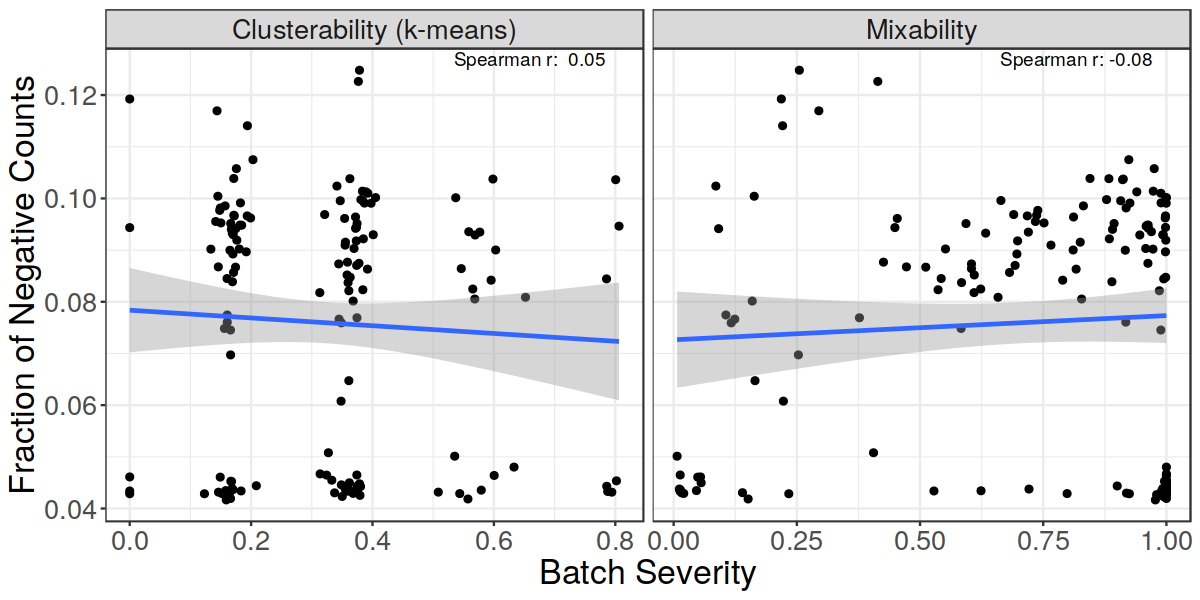

In [24]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

gA<-ggplot(data = viz.df_, aes(x = batch.severity, y = scanorama_frac.negative)) + 
geom_point() + geom_smooth(method = glm) +
facet_wrap(~batch.severity.metric, ncol = 3, scales = 'free_x') + 
geom_text(data = data.frame(spearman.corrs),
          mapping = aes(x = Inf, y = Inf, 
                        label = paste0('Spearman r: ', format(round(correlation, 2), nsmall = 2))), 
          hjust = 1.25, vjust = 1.25) + 
theme_bw() + ylab('Fraction of Negative Counts') + xlab('Batch Severity') + 
theme(text=element_text(size=20))

gA

It looks like there is not a strong relationship between the fraction of negative counts and batch severity. Let's ensure this using a glm. Because Louvain does not change at all with batch severity, we make this the baseline metric in the categorical factor encoding. 

In [25]:
contrasts(viz.df$batch.severity.metric)

,Clusterability (k-means),Mixability
Clusterability (Louvain),0,0
Clusterability (k-means),1,0
Mixability,0,1


In [26]:
mod<-glm(data = viz.df, formula = scanorama_frac.negative ~ batch.severity + batch.severity.metric)
mod.res<-as.data.frame(coef(summary(mod)))[, c('Estimate', 'Pr(>|t|)')]
mod.res[['BH.FDR']]<-unname(unlist(p.adjust(mod.res[, 2], method = "BH")))
sig.thresh<-0.1
mod.res[['Significant']]<-'no'
# include NA since these are not changing
mod.res[(!is.na(mod.res$BH.FDR)) & (mod.res$BH.FDR <= sig.thresh), 'Significant']<-'yes'
mod.res[['Significant']]<-factor(mod.res$Significant, levels = c('yes', 'no'))
mod.res <- mod.res %>% tibble::rownames_to_column("coefficient")
mod.res[mod.res$coefficient == ('(Intercept)'), 'coefficient']<-'Intercept'

# mapping for visualization
coefficient_map<-c('Intercept', 'Batch Severity', 'Factor: \n Clusterability (k-means)', 
                   'Factor: Mixability')
names(coefficient_map)<-c('Intercept', 'batch.severity', 'batch.severity.metricClusterability (k-means)', 
                          'batch.severity.metricMixability')
mod.res[['coefficient']]<-factor(unlist(unname(coefficient_map[mod.res$coefficient])), 
                                 levels = unlist(unname(coefficient_map)))

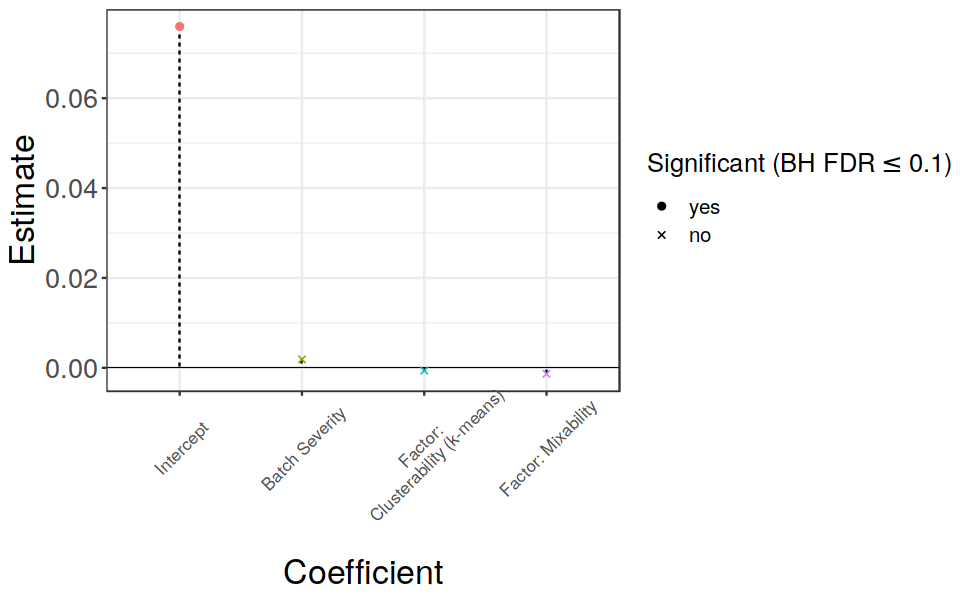

In [27]:
h_ = 5
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)



gB<-ggplot(data = mod.res, aes(x = coefficient, y = Estimate, color = coefficient)) +
geom_hline(yintercept = 0, size = 0.25)+
geom_segment(aes(x=coefficient, xend=coefficient, y=Estimate, yend=0), 
        size=0.5, data=mod.res, color = 'black', linetype="dashed") +
geom_point(aes(shape = Significant)) + scale_shape_manual(name = expression('Significant (BH FDR' <= '0.1)'), 
                                                          values=c(19,4), drop = F) + 
guides(color = F) + xlab('Coefficient') +
theme_bw() + 
theme(text=element_text(size=20), 
      axis.text.x = element_text(size = 10, angle = 45, vjust = 0.7, hjust=0.5), 
     legend.title=element_text(size=15), legend.text=element_text(size=12))

gB

We see that the effect of batch severity on the fraction of negative counts introduced by scanorama is small (0.002) and insignificant (p-val > 0.05). Based on these results, we can asssess whether introducing more negative counts affects decomposition without worrying about batch severity as a confounder. 

In [28]:
viz.df<-res.df[c('corrindex.scanorama', 'scanorama_frac.negative')]
sr<-cor(viz.df$scanorama_frac.negative, viz.df$corrindex.scanorama, method = "sp", use = 'pairwise.complete.obs')
mod<-glm(data = viz.df, formula = corrindex.scanorama ~ scanorama_frac.negative)
mod.res<-coef(summary(mod))['scanorama_frac.negative', c('Estimate', 'Pr(>|t|)')]
names(mod.res)<-c('Estimate', 'p.val')

`geom_smooth()` using formula = 'y ~ x'


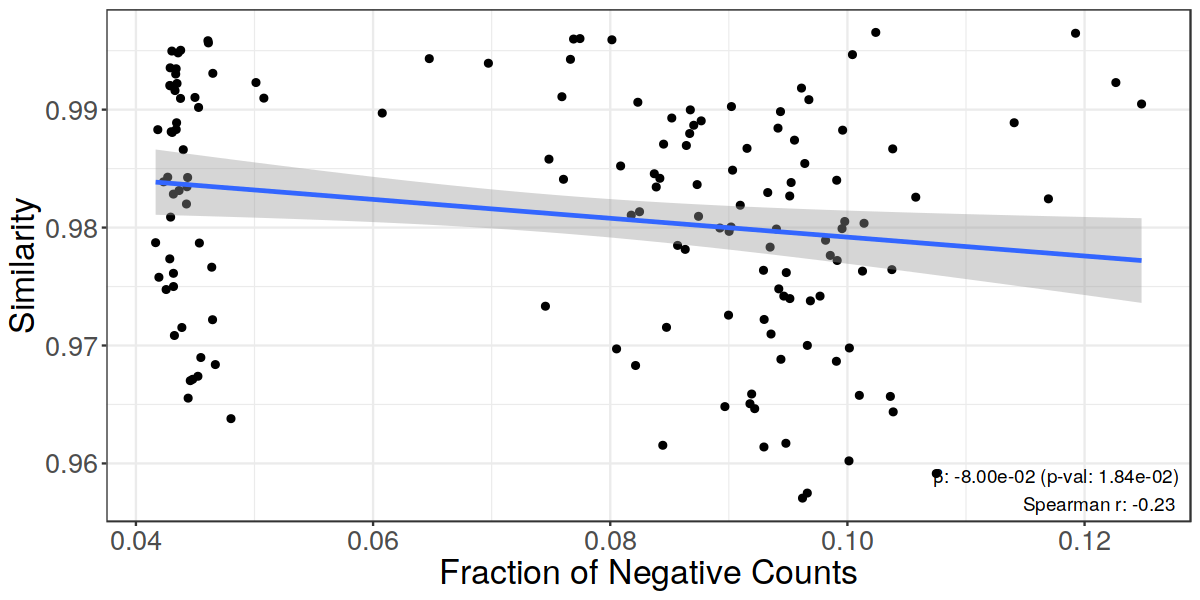

In [29]:
h_ = 5
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

gC<-ggplot(data = viz.df, aes(x = scanorama_frac.negative, y = corrindex.scanorama)) + 
geom_point() + geom_smooth(method = glm) +
geom_text(data = data.frame(correlation = sr),
          mapping = aes(x = Inf, y = -Inf, 
                        label = paste0('Spearman r: ', format(round(correlation, 2), nsmall = 2))), 
          hjust = 1.1, vjust = -0.75) +
geom_text(data = as.data.frame(t(mod.res)),
          mapping = aes(x = Inf, y = -Inf, label = paste0("\U03B2", ': ', 
                                                           formatC(Estimate, format = "e", digits = 2),
                                                           ' (p-val: ', 
                                                          formatC(p.val, format = "e", digits = 2), 
                                                          ')')), 
         hjust = 1.05,vjust   = -2.75) +
theme_bw() + theme(text=element_text(size=20)) + 
ylab('Similarity') + xlab('Fraction of Negative Counts')

gC

While there is a moderate negative correlation, it appears that the fraction of negative counts does not substantially affect the decomposition similarity as indicated by the regression coefficient estimate and p-value. This tells us that using batch correction methods that introduce negative counts, then simply replacing those values with 0 prior to running communication scoring, may be okay if necessary. 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -8.00e-02 (p-val: 1.84e-02)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -8.00e-02 (p-val: 1.84e-02)' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -8.00e-02 (p-val: 1.84e-02)' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'β: -8.00e-02 (p-val: 1.84e-02)' in 'mbcsToSbcs': dot substituted for <b2>”


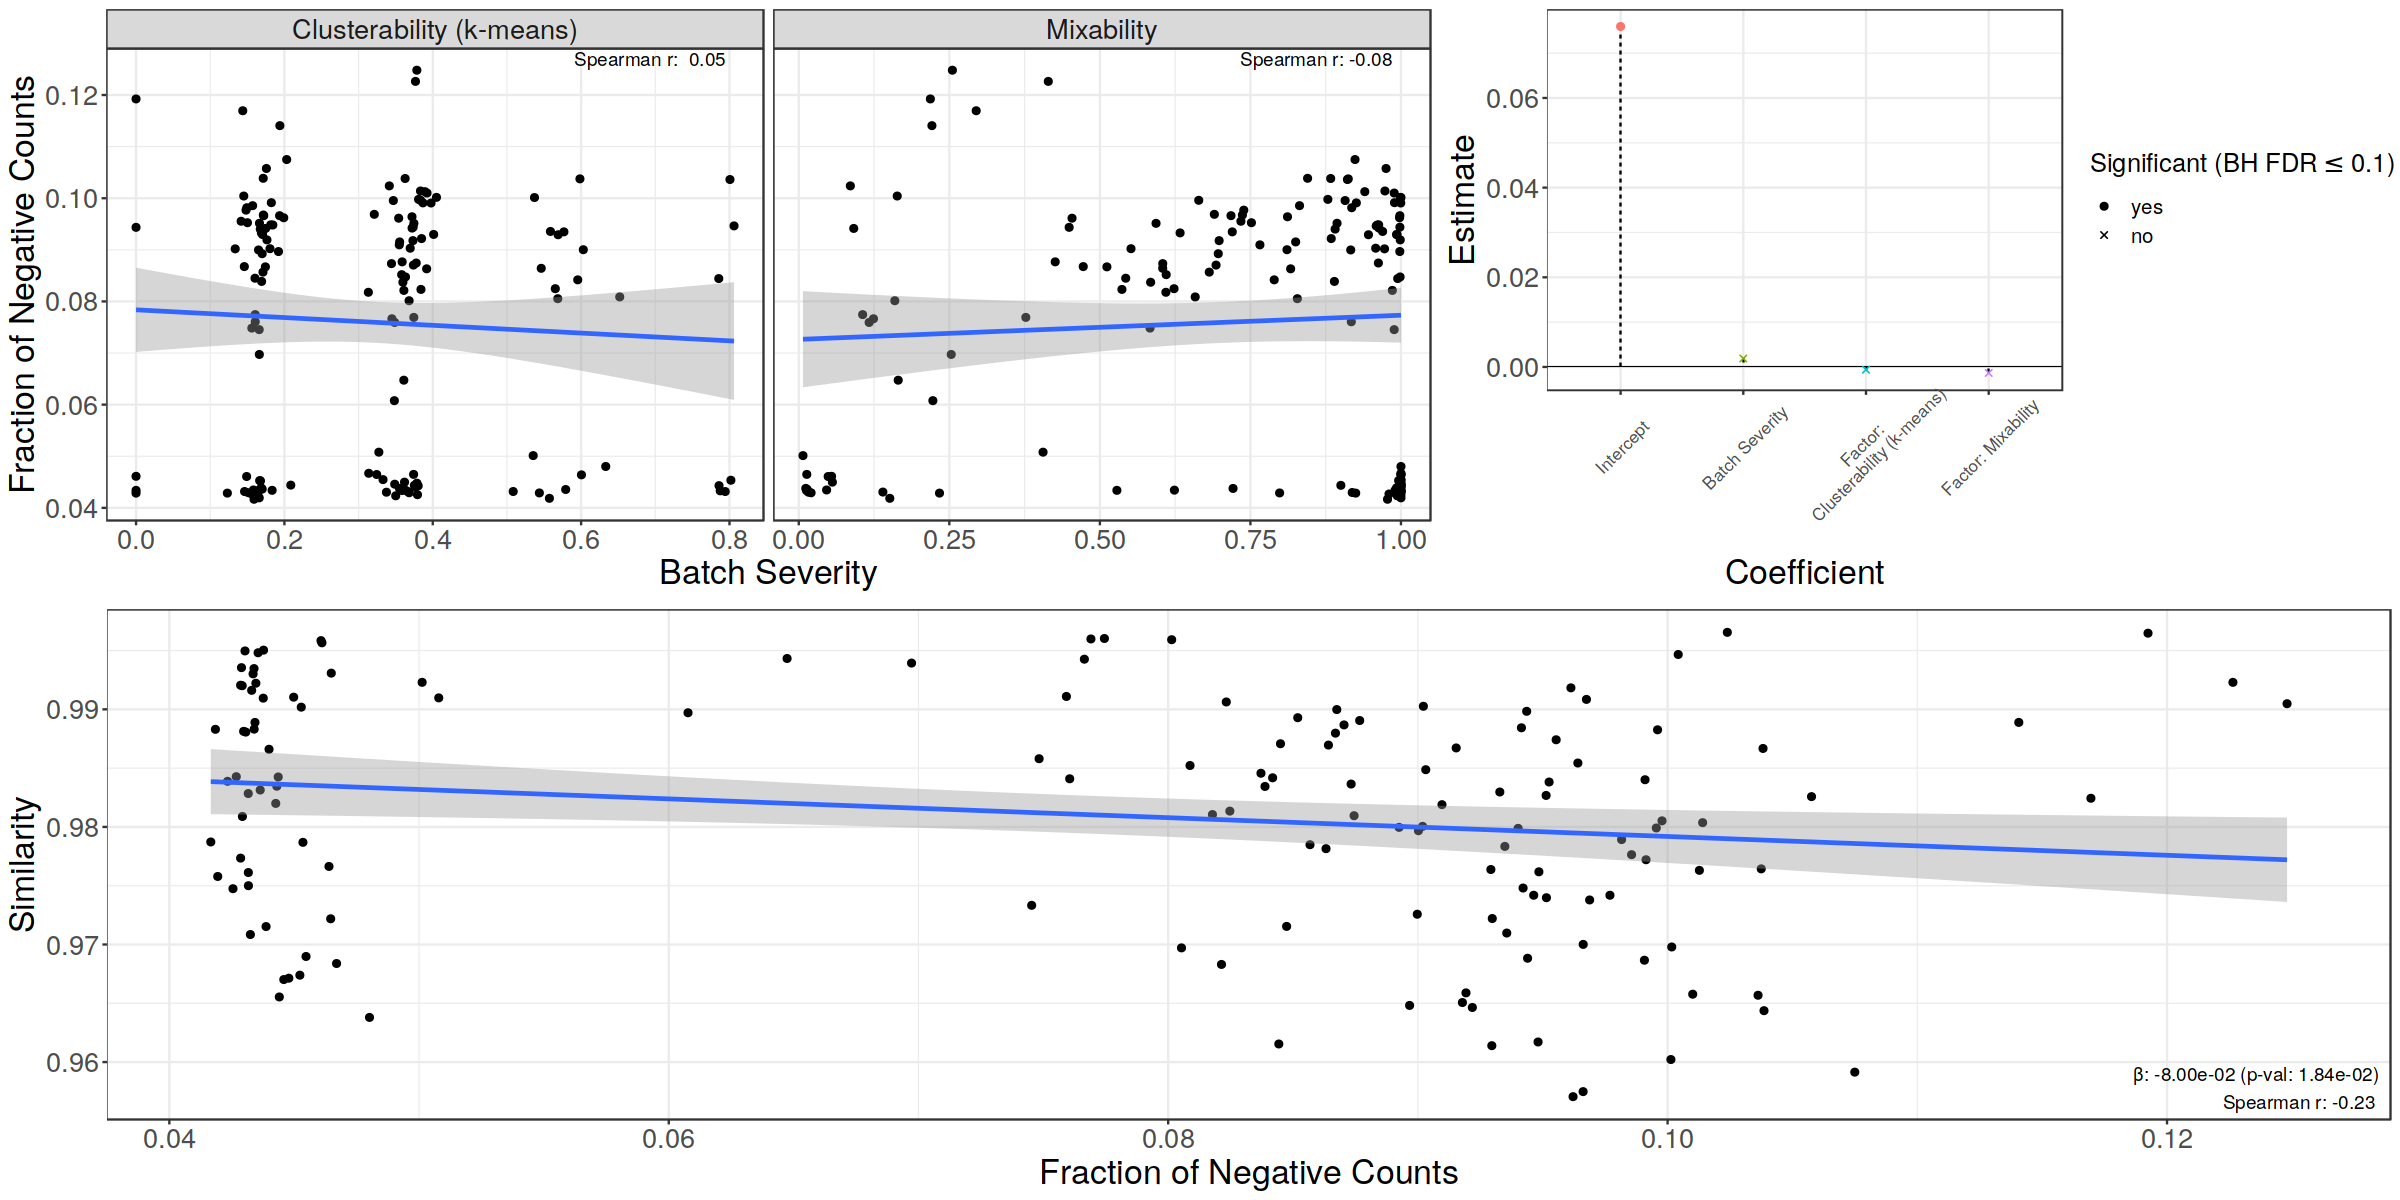

In [30]:
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g<-cowplot::plot_grid(gA, gB, rel_widths = c(0.6, 0.4))
g<-cowplot::plot_grid(g, gC, ncol = 1)

fn<-'fracnegative_effect'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g, 
                                             height = h_, width = w_)}

g

In [31]:
mf<-max(viz.df$scanorama_frac.negative)
paste0('The maximum fraction of negative counts introduces is: ', format(round(mf, 3), nsmall = 3))

[1] "The maximum fraction of negative counts introduces is: 0.125"

#### 4B: Does batch correction improve decomposition results?

Here, we see whether introducing a batch correction improves our decomposition results (as measured by decompsition similarity to the gold-standard counts matrix). To do this, across the batch severity , we compare Similarity A to Similarity B, where:

- batch severity is measured in the log counts matrix (before batch correction)
- Similarity A is the decomposition similarity between the batch corrected matrix and gold-standard matrix
- Similarity B is the decomposition similarity between the log-counts matrix and gold-standard matrix

If batch correction helps, we expect that Similarity A should be higher than B across batch severity levels. 

In [32]:
viz.df<-res.df[c('corrindex.scanorama', 'corrindex.scvi', 'corr.index.log', 
                 'log_clusterability.kmeans', 'log_clusterability.louvain', 'log_mixability')]
viz.df<-reshape2::melt(viz.df, id.vars = c('log_clusterability.kmeans', 'log_clusterability.louvain', 'log_mixability'), 
              variable.name = 'Similarity.Type', value.name = 'Similarity')
viz.df[['Similarity.Type']]<-sapply(viz.df$Similarity.Type, function(x) gsub("corrindex.", "", x))
viz.df[['Similarity.Type']]<-sapply(viz.df$Similarity.Type, function(x) gsub("corr.index.", "", x))
viz.df<-reshape2::melt(viz.df, id.vars = c('Similarity.Type', 'Similarity'), 
               variable.name = 'batch.severity.metric', value.name = 'batch.severity')

# mapping for visualization
batch.metric.map<-c('Clusterability (k-means)', 'Clusterability (Louvain)', 'Mixability')
names(batch.metric.map)<-c('log_clusterability.kmeans', 'log_clusterability.louvain', 'log_mixability')
viz.df[['batch.severity.metric']]<-factor(unlist(unname(batch.metric.map[viz.df$batch.severity.metric])), 
                                 levels = unlist(unname(batch.metric.map)))

count.type.map<-c('Log-normalized', 'Scanorama', 'scVI')
names(count.type.map)<-c('log', 'scanorama', 'scvi')
viz.df[['Similarity.Type']]<-factor(unlist(unname(count.type.map[viz.df$Similarity.Type])), 
                                 levels = unlist(unname(count.type.map)))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 231 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”


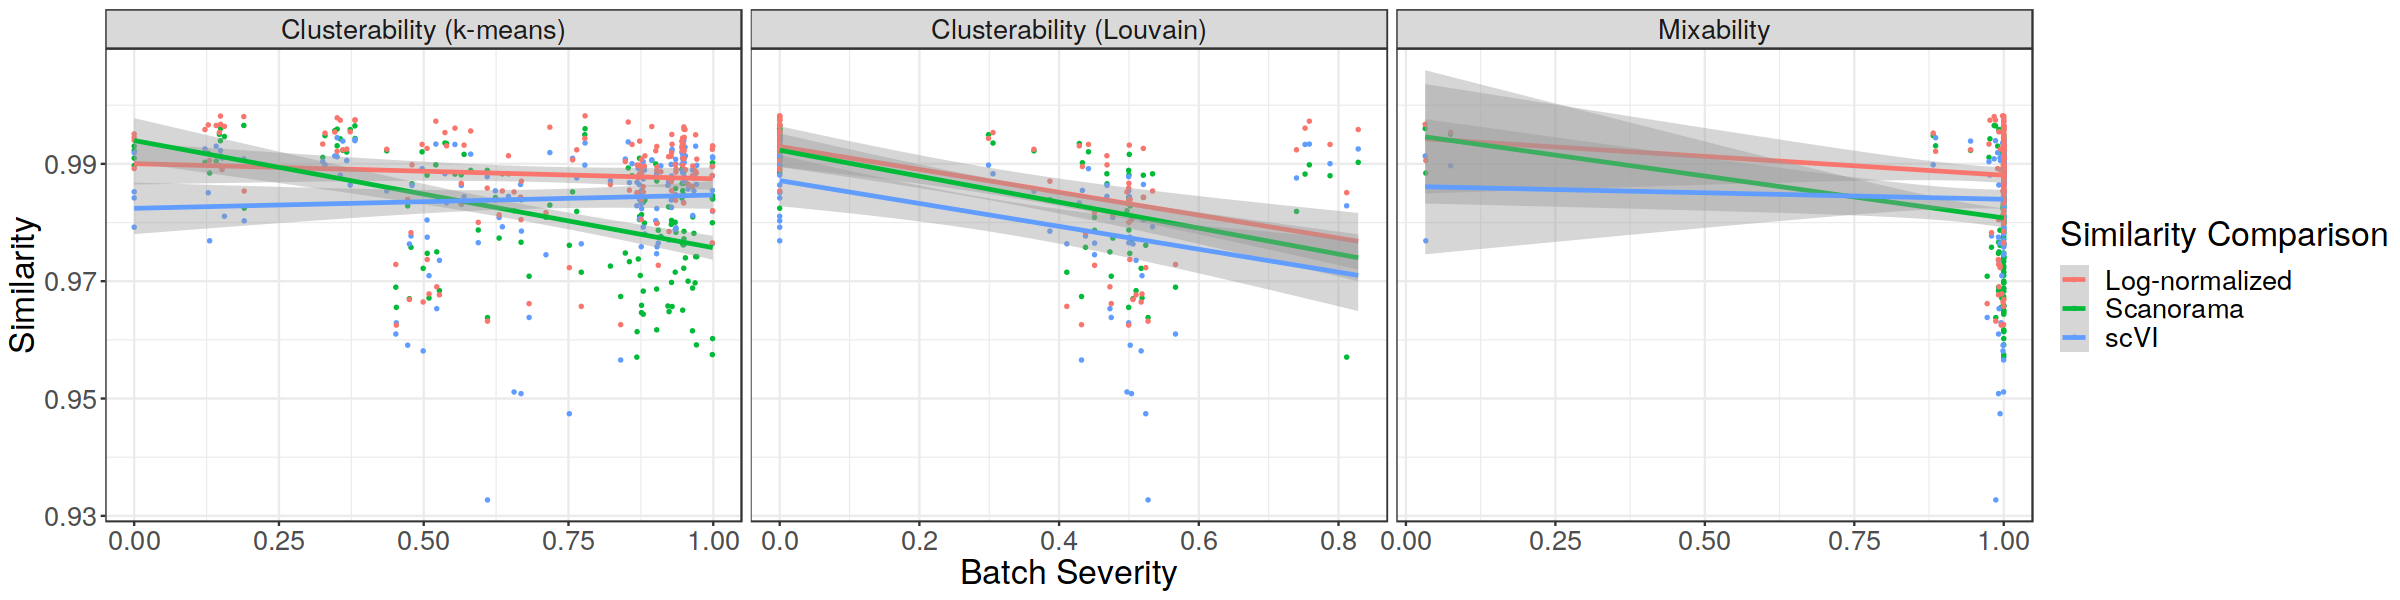

In [33]:
h_ = 5
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

gA<-ggplot(data = viz.df, aes(x = batch.severity, y = Similarity, color = Similarity.Type)) + 
geom_jitter(size = 0.5) + geom_smooth(method = glm) + 
facet_wrap(~batch.severity.metric, ncol = 3, scales = 'free_x') + 
xlab('Batch Severity') +
theme_bw() + theme(text=element_text(size=20)) +
guides(color=guide_legend(title="Similarity Comparison"))

gA

Visually, it appears that there is not much difference between Similarity A and Similarity B. Let's confirm this using a regression model that controls for the batch severity metric and level:

In [34]:
contrasts(viz.df$Similarity.Type)
contrasts(viz.df$batch.severity.metric)

,Scanorama,scVI
Log-normalized,0,0
Scanorama,1,0
scVI,0,1


,Clusterability (Louvain),Mixability
Clusterability (k-means),0,0
Clusterability (Louvain),1,0
Mixability,0,1


In [35]:
head(viz.df)

,Similarity.Type,Similarity,batch.severity.metric,batch.severity
,<fct>,<dbl>,<fct>,<dbl>
1,Scanorama,0.9950357,Clusterability (k-means),0.1471207
2,Scanorama,0.9948118,Clusterability (k-means),0.3295178
3,Scanorama,0.9958453,Clusterability (k-means),0.3730803
4,Scanorama,0.9920516,Clusterability (k-means),0.4971943
5,Scanorama,0.9773469,Clusterability (k-means),0.6302426
6,Scanorama,0.9787198,Clusterability (k-means),0.5941823


In [36]:
mod<-glm(data = viz.df, formula = Similarity ~ Similarity.Type + batch.severity + batch.severity.metric)
mod.res<-as.data.frame(coef(summary(mod)))[, c('Estimate', 'Pr(>|t|)')]
mod.res[['BH.FDR']]<-unname(unlist(p.adjust(mod.res[, 2], method = "BH")))
sig.thresh<-0.1
mod.res[['Significant']]<-'no'
# include NA since these are not changing
mod.res[(!is.na(mod.res$BH.FDR)) & (mod.res$BH.FDR <= sig.thresh), 'Significant']<-'yes'
mod.res[['Significant']]<-factor(mod.res$Significant, levels = c('yes', 'no'))
mod.res <- mod.res %>% tibble::rownames_to_column("coefficient")
mod.res[mod.res$coefficient == ('(Intercept)'), 'coefficient']<-'Intercept'
# mapping for visualization
coefficient_map<-c('Intercept', 
                   'Factor: \n Scanorama Similarity Comparison', 'Factor: \n scVI Similarity Comparison', 
                   'Batch Severity',
                  'Factor: \n Clusterability (Louvain)', 'Factor: Mixability')
names(coefficient_map)<-c('Intercept', 'Similarity.TypeScanorama', 'Similarity.TypescVI', 
                         'batch.severity', 'batch.severity.metricClusterability (Louvain)', 
                         'batch.severity.metricMixability')
mod.res[['coefficient']]<-factor(unlist(unname(coefficient_map[mod.res$coefficient])), 
                                 levels = unlist(unname(coefficient_map)))

mod.res.viz<-mod.res[mod.res$coefficient != 'Intercept', ]
mod.res.viz[['coefficient']]<-droplevels(mod.res.viz$coefficient)

In [39]:
mod.res

coefficient,Estimate,Pr(>|t|),BH.FDR,Significant
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Intercept,0.995062339,0.000000e+00,0.000000e+00,yes
Factor: Scanorama Similarity Comparison,-0.006021881,1.240389e-16,3.721168e-16,yes
Factor: scVI Similarity Comparison,-0.004509025,4.321488e-10,6.482232e-10,yes
Batch Severity,-0.010089600,4.807363e-15,9.614726e-15,yes
Factor: Clusterability (Louvain),-0.003997453,2.665501e-05,3.198602e-05,yes
Factor: Mixability,0.002753341,1.961130e-04,1.961130e-04,yes


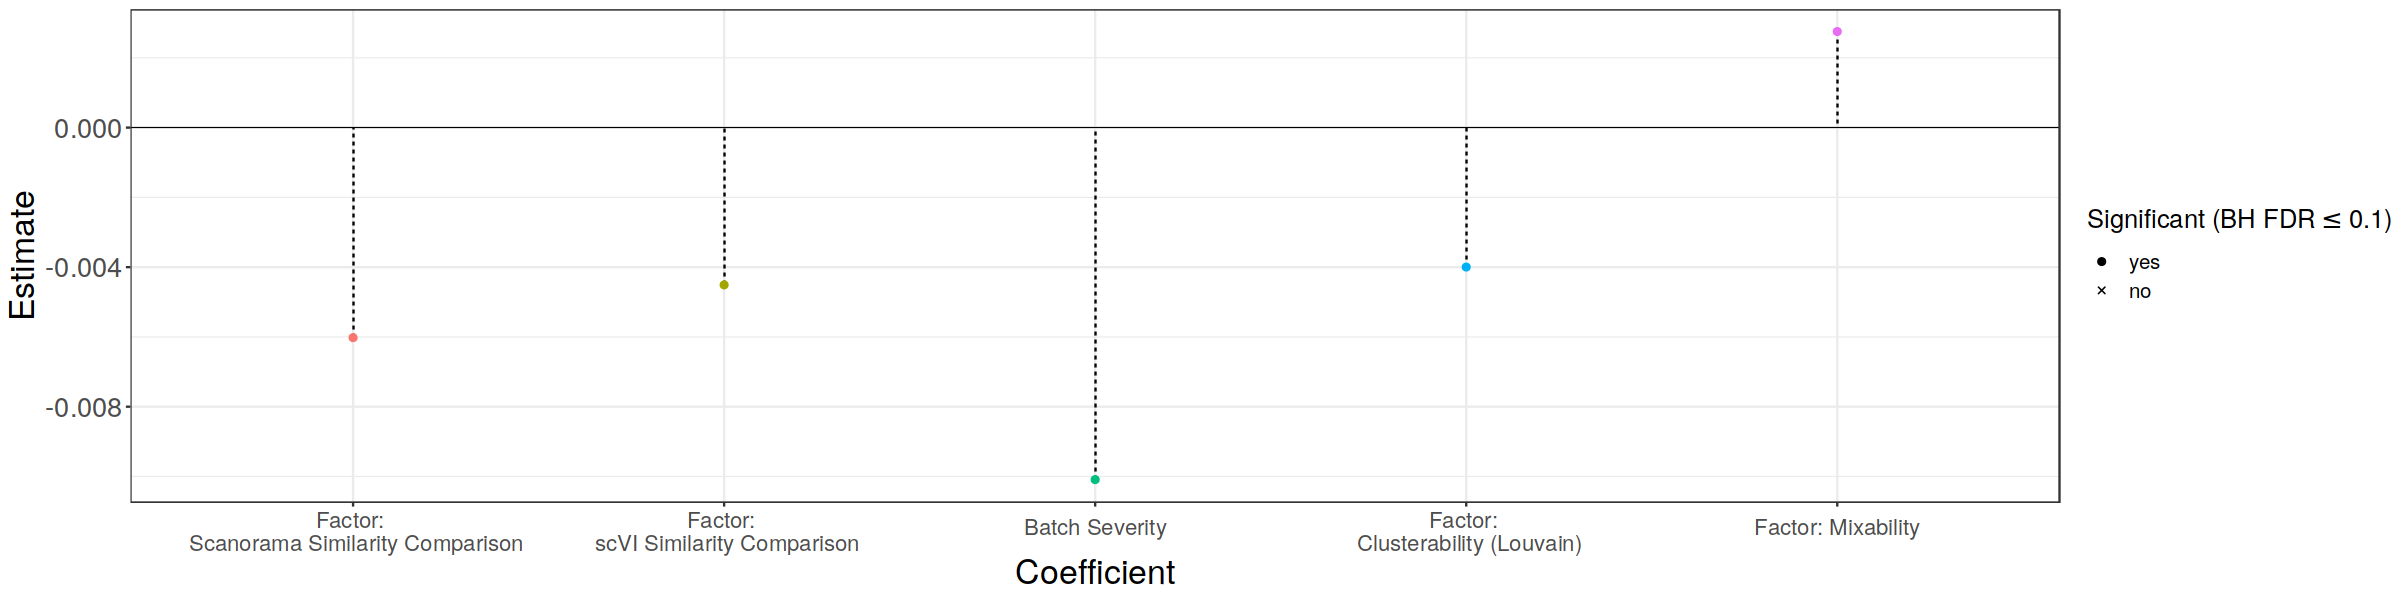

In [37]:
gB<-ggplot(data = mod.res.viz, 
           aes(x = coefficient, y = Estimate, color = coefficient)) +
geom_hline(yintercept = 0, size = 0.25)+
geom_segment(aes(x=coefficient, xend=coefficient, y=Estimate, yend=0), 
        size=0.5, data=mod.res.viz, color = 'black', linetype="dashed") +
geom_point(aes(shape = Significant)) + scale_shape_manual(name = expression('Significant (BH FDR' <= '0.1)'), 
                                                          values=c(19,4), drop = F) + 
theme_bw() +
theme(text=element_text(size=20), 
      axis.text.x = element_text(size = 13, angle = 0, vjust = 0.7, hjust=0.5), 
     legend.title=element_text(size=15), legend.text=element_text(size=12)) + 
guides(color = F) + xlab('Coefficient')

gB

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 231 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 231 rows containing missing values (`geom_point()`).”


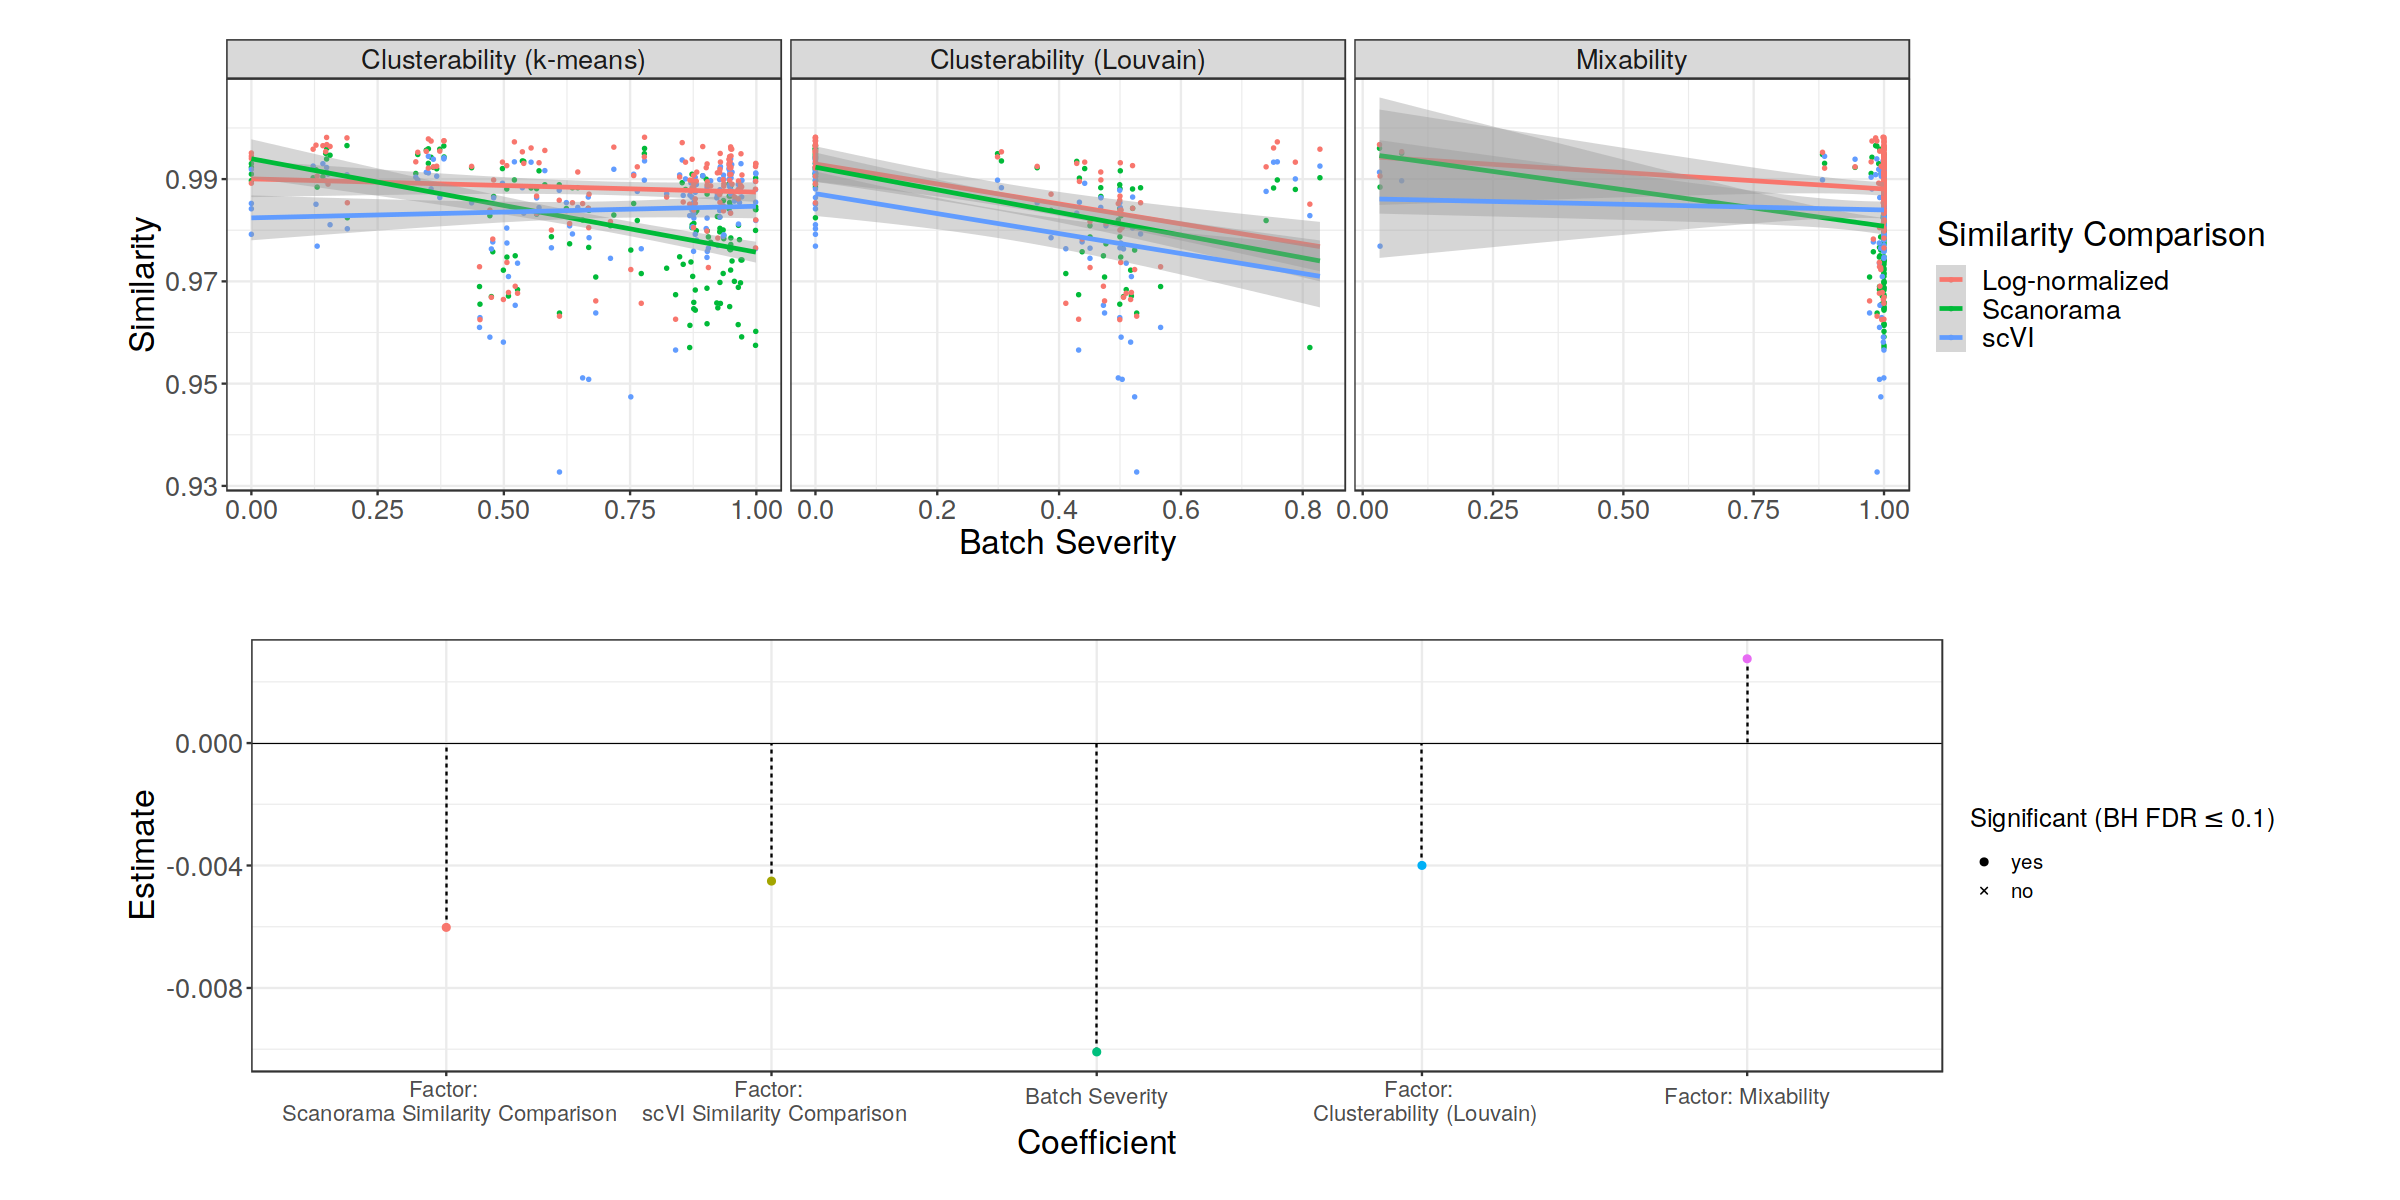

In [38]:
h_ = 10
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g<-cowplot::plot_grid(gA, gB, ncol = 1, scale = 0.9)

fn<-'batchcorrection_effect'
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(fig.path, fn, ext), g, 
                                             height = h_, width = w_)}

g

Here, after controlling for the batch severity level and batch severity metric as covariates in the model, we see that the decompsoition similarity of the batch corrected counts (scvi and scanorama) as compared to the log-counts (level 0) are statistically significant and have negative coefficients. The negative coefficients can be interpreted as the Similarity in fact decreasing more with batch correction relative to just using the log-counts matrix; however, given the small values/effect sizes here, they are negligible.  

**<font color='red'>Need to check whether this interpretation is correct, particularly that other dependent variables can be included in this manner to control for the dependent variable of interest (Similarity.Type) in a multivariate model with combined categorical and continuous variables. The other two variables that are being controlled for are batch.severity (continuous) and batch.severity.metric (categorical)</font>**

Overall, it appears that there is not much difference between the log-counts similarity and the batch-corrected counts. This goes back to the results from Question 3. It seems that, in general, batch correction doesn't worsen results, even when introducing negative counts, so users can proceed either with the log-counts or batch corrected matrix. If they visually see technical effects in the factors output by Tensor-cell2cell (see paragraph 3 in [README](./README.md) regarding replicates with different loading values), running batch correction prior to communication scoring may make sense. 